Class 0: 204
Class 1: 54
Class 2: 69
Class 3: 15
Class 4: 7
Sampled class counts in one epoch:
Class 0: 287
Class 1: 252
Class 2: 271
Class 3: 298
Class 4: 287
Epoch [1/10], Loss: 1.1704, Accuracy: 49.25%, Recall: 0.49, Precision: 0.49, Specificity: 0.87, F1-Score: 0.49
Epoch [2/10], Loss: 0.6907, Accuracy: 72.26%, Recall: 0.72, Precision: 0.72, Specificity: 0.93, F1-Score: 0.72
Epoch [3/10], Loss: 0.5334, Accuracy: 79.21%, Recall: 0.79, Precision: 0.79, Specificity: 0.95, F1-Score: 0.79
Epoch [4/10], Loss: 0.4110, Accuracy: 83.94%, Recall: 0.83, Precision: 0.84, Specificity: 0.96, F1-Score: 0.83
Epoch [5/10], Loss: 0.3291, Accuracy: 87.81%, Recall: 0.88, Precision: 0.88, Specificity: 0.97, F1-Score: 0.88
Epoch [6/10], Loss: 0.2984, Accuracy: 87.81%, Recall: 0.88, Precision: 0.88, Specificity: 0.97, F1-Score: 0.88
Epoch [7/10], Loss: 0.2456, Accuracy: 90.82%, Recall: 0.91, Precision: 0.91, Specificity: 0.98, F1-Score: 0.91
Epoch [8/10], Loss: 0.1893, Accuracy: 93.62%, Recall: 0.93, Pre

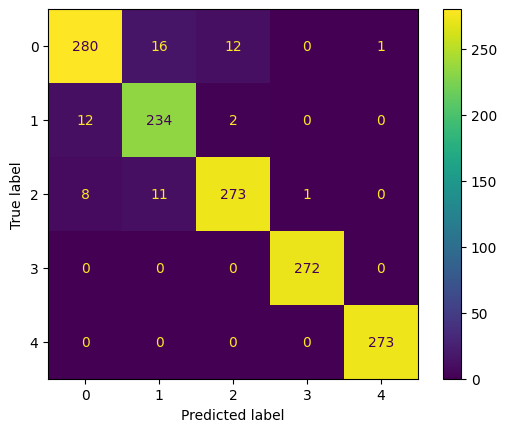

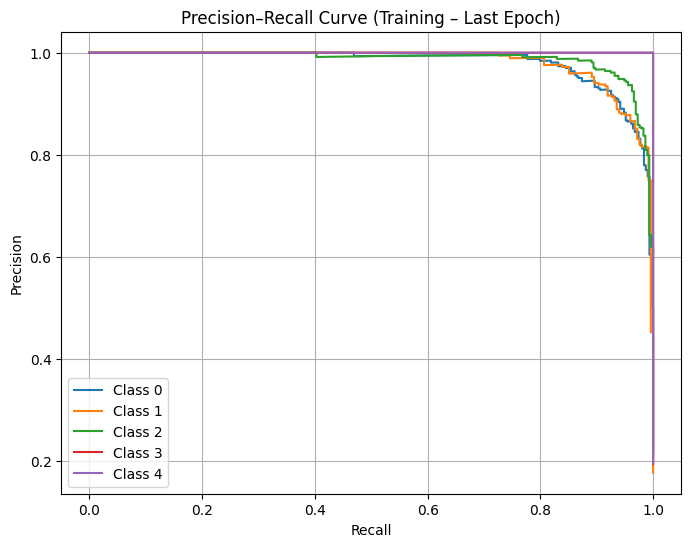

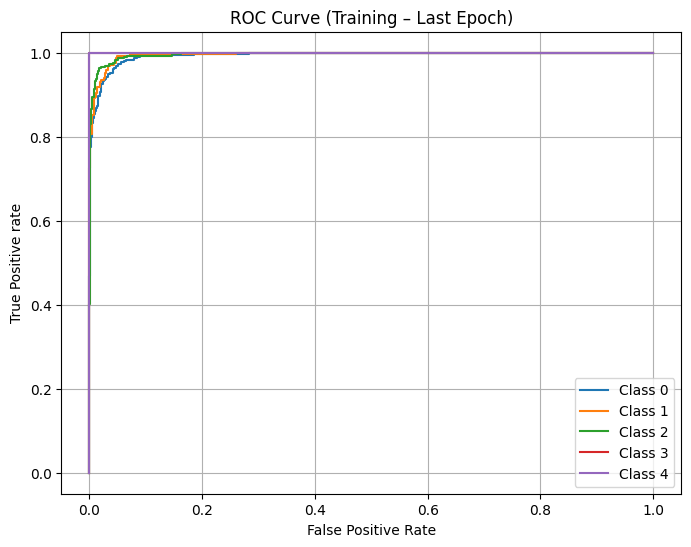

Test Accuracy: 64.47%, Recall: 0.35, Precision: 0.41, Specificity: 0.87, F1-Score: 0.37
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.90      0.82       204
           1       0.12      0.06      0.08        54
           2       0.48      0.48      0.48        69
           3       0.71      0.33      0.45        15
           4       0.00      0.00      0.00         7

    accuracy                           0.64       349
   macro avg       0.41      0.35      0.37       349
weighted avg       0.58      0.64      0.60       349



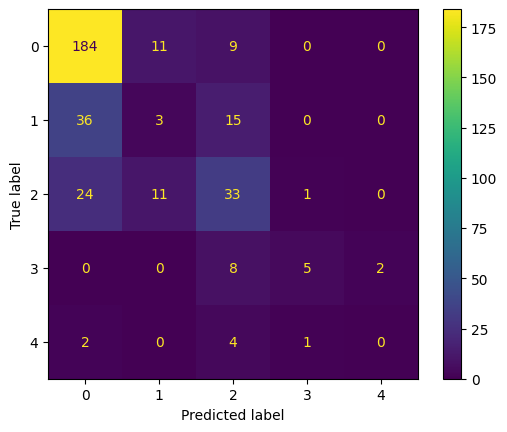

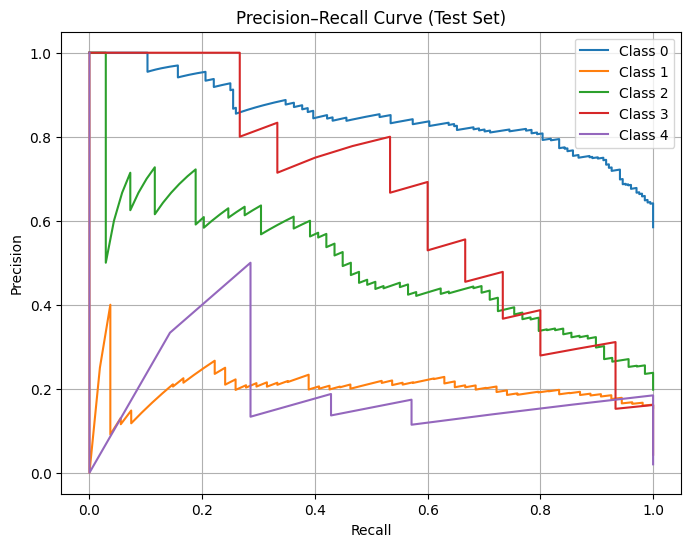

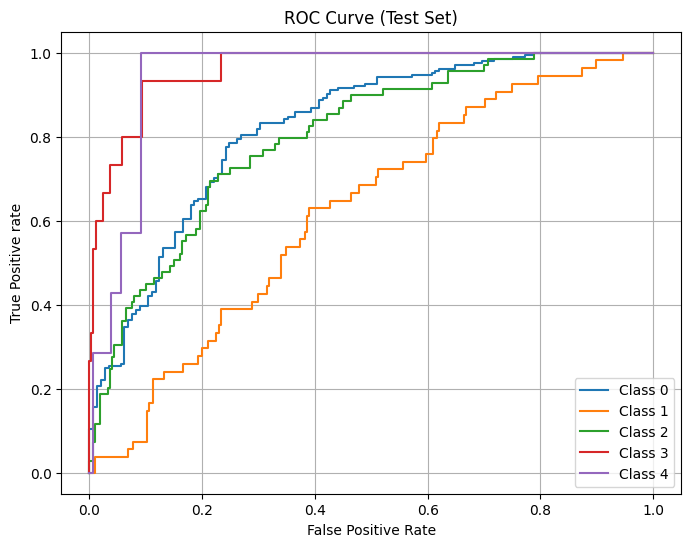

In [1]:
#With sampling

import torch
import torchvision.transforms as transforms
from torchvision.transforms import v2
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision, MulticlassSpecificity, MulticlassF1Score
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
from collections import Counter

# Image transformer

train_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(10),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Creates a custom dataset. Initialised with the csv file, image file and transformeded.

class messidorDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = Image.open(img_path).convert("RGB")
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

# Get the images and csv data file

annotations_file = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor_data.csv"
img_dir = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor-2/preprocess"
af = pd.read_csv(annotations_file)
num_imgs = len(af)
label = af.iloc[:, 1].values
indices = np.arange(len(af))

# Splits the dataset into training and testing sets in 80:20 ratio respectively

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(sss.split(indices, label))

training_dataset = messidorDataset(annotations_file, img_dir, train_transform)
testing_dataset = messidorDataset(annotations_file, img_dir, test_transform)

train_dataset = Subset(training_dataset, train_index)
test_dataset = Subset(testing_dataset, test_index)

targets = training_dataset.img_labels.iloc[train_dataset.indices, 1].values
num_samples = len(targets)
class_counts = torch.bincount(torch.tensor(targets))
sample_weights = torch.tensor([1.0 / class_counts[t] for t in targets])
train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

labels = testing_dataset.img_labels.iloc[test_dataset.indices, 1].values
unique, counts = np.unique(labels, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Class {u}: {c}")

# Loads the dataset, batchsize and shuffles the dataset

train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_counter = Counter()

for inputs, labels in train_loader:
    class_counter.update(labels.tolist())

print("Sampled class counts in one epoch:")
for cls in sorted(class_counter.keys()):
    print(f"Class {cls}: {class_counter[cls]}")

# Load ResNet18

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# This replaces the final layer of the model to output 5 classes instead of 1000

model.fc = torch.nn.Linear(
    in_features=model.fc.in_features,
    out_features=5
)

# Freeze all layers except the last two layers.

for param in model.parameters():
    param.requires_grad = False
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Uses cuda if available or it uses cpu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss function and optimizer

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {"params": model.layer3.parameters(), "lr": 1e-4},
    {"params": model.layer4.parameters(), "lr": 1e-4},
    {"params": model.fc.parameters(), "lr": 1e-3},
])

# Model training

total_epoch = 10
recall_macro = MulticlassRecall(num_classes=5, average="macro").to(device)
precision_macro = MulticlassPrecision(num_classes=5, average="macro").to(device)
specificity_macro = MulticlassSpecificity(num_classes=5, average="macro").to(device)
f1score_macro = MulticlassF1Score(num_classes=5, average="macro").to(device)
train_probs = []
pred_val = []
all_labels = []
for epoch in range(total_epoch):
    model.train()
    recall_macro.reset()
    precision_macro.reset()
    specificity_macro.reset()
    f1score_macro.reset()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        if epoch == total_epoch-1:
            probs = torch.softmax(outputs, dim=1)
            train_probs.append(probs.detach().numpy())
            pred_val.append(predicted.detach().numpy())
            all_labels.append(labels.detach().numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)

    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
    print(f'Epoch [{epoch+1}/{total_epoch}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
train_probs = np.concatenate(train_probs, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
recall_macro.reset()
precision_macro.reset()
specificity_macro.reset()
f1score_macro.reset()
correct = 0
total = 0
test_probs = []
pred_val = []
all_labels = []

# Model testing

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        probs = torch.softmax(outputs, dim=1)
        test_probs.append(probs.numpy())
        pred_val.append(predicted.numpy())
        all_labels.append(labels.numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)
    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
test_probs = np.concatenate(test_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))

for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()



Class 0: 204
Class 1: 54
Class 2: 69
Class 3: 15
Class 4: 7
Sampled class counts in one epoch:
Class 0: 813
Class 1: 216
Class 2: 278
Class 3: 60
Class 4: 28
Epoch [1/10], Loss: 1.1195, Accuracy: 56.06%, Recall: 0.26, Precision: 0.27, Specificity: 0.84, F1-Score: 0.26
Epoch [2/10], Loss: 0.7855, Accuracy: 68.67%, Recall: 0.45, Precision: 0.65, Specificity: 0.88, F1-Score: 0.48
Epoch [3/10], Loss: 0.6600, Accuracy: 73.48%, Recall: 0.54, Precision: 0.71, Specificity: 0.90, F1-Score: 0.59
Epoch [4/10], Loss: 0.4985, Accuracy: 81.79%, Recall: 0.68, Precision: 0.82, Specificity: 0.93, F1-Score: 0.74
Epoch [5/10], Loss: 0.3859, Accuracy: 87.89%, Recall: 0.80, Precision: 0.89, Specificity: 0.96, F1-Score: 0.83
Epoch [6/10], Loss: 0.3036, Accuracy: 89.89%, Recall: 0.86, Precision: 0.90, Specificity: 0.96, F1-Score: 0.88
Epoch [7/10], Loss: 0.2293, Accuracy: 93.12%, Recall: 0.89, Precision: 0.93, Specificity: 0.98, F1-Score: 0.91
Epoch [8/10], Loss: 0.1947, Accuracy: 93.62%, Recall: 0.92, Preci

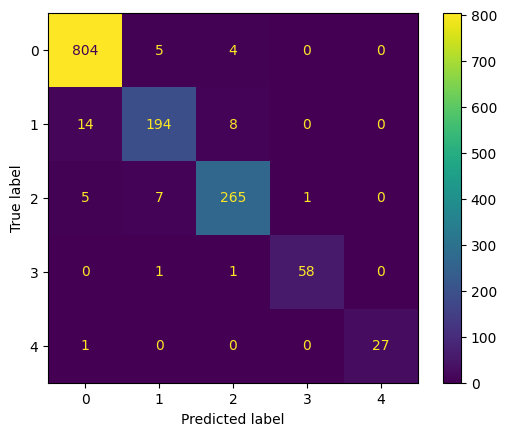

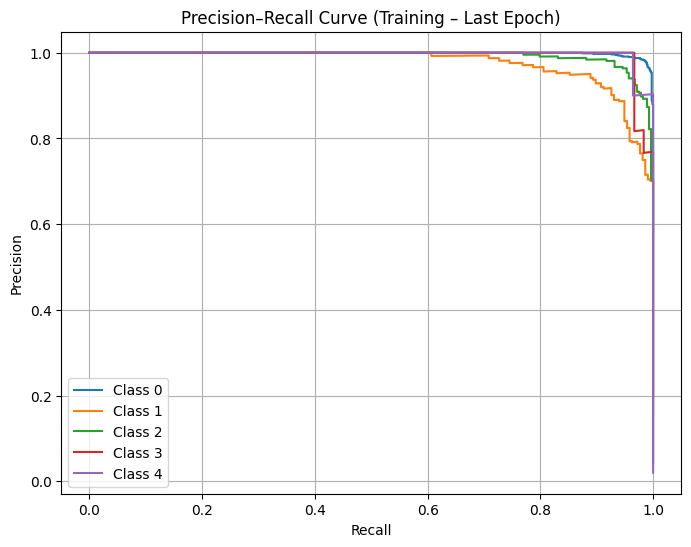

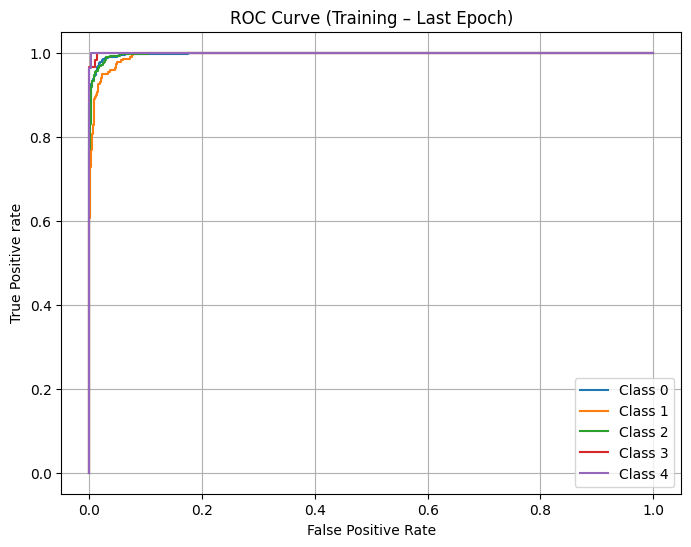

Test Accuracy: 66.48%, Recall: 0.40, Precision: 0.44, Specificity: 0.87, F1-Score: 0.42
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.91      0.82       204
           1       0.23      0.13      0.17        54
           2       0.56      0.45      0.50        69
           3       0.67      0.53      0.59        15
           4       0.00      0.00      0.00         7

    accuracy                           0.66       349
   macro avg       0.44      0.40      0.42       349
weighted avg       0.61      0.66      0.63       349



/home/matth/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/matth/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/matth/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

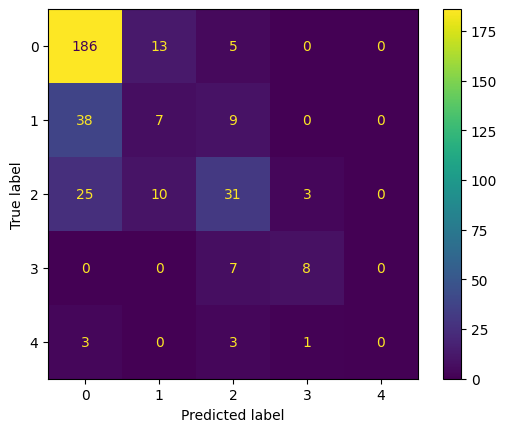

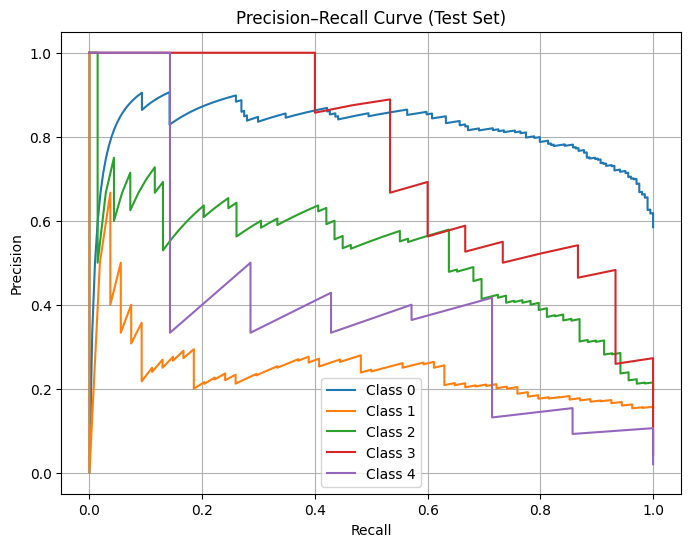

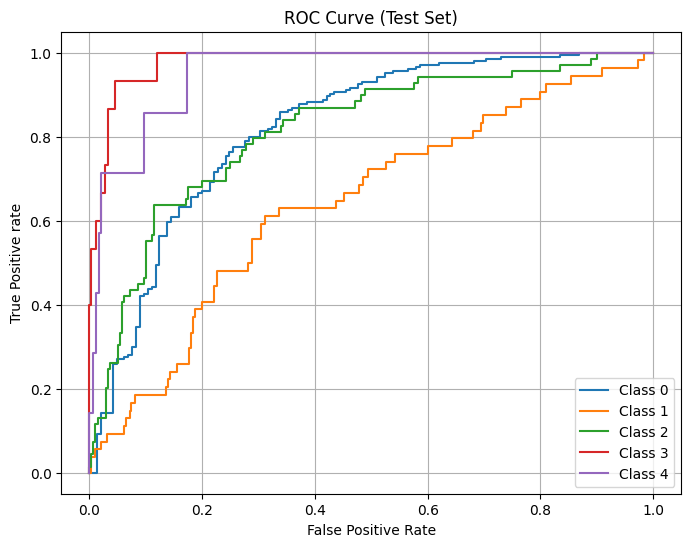

In [2]:
#Without Sampling

import torch
import torchvision.transforms as transforms
from torchvision.transforms import v2
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision, MulticlassSpecificity, MulticlassF1Score
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
from collections import Counter

# Image transformer

train_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(10),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Creates a custom dataset. Initialised with the csv file, image file and transformeded.

class messidorDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = Image.open(img_path).convert("RGB")
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

# Get the images and csv data file

annotations_file = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor_data.csv"
img_dir = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor-2/preprocess"
af = pd.read_csv(annotations_file)
num_imgs = len(af)
label = af.iloc[:, 1].values
indices = np.arange(len(af))

# Splits the dataset into training and testing sets in 80:20 ratio respectively

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(sss.split(indices, label))

training_dataset = messidorDataset(annotations_file, img_dir, train_transform)
testing_dataset = messidorDataset(annotations_file, img_dir, test_transform)

train_dataset = Subset(training_dataset, train_index)
test_dataset = Subset(testing_dataset, test_index)

targets = training_dataset.img_labels.iloc[train_dataset.indices, 1].values
num_samples = len(targets)
class_counts = torch.bincount(torch.tensor(targets))
sample_weights = torch.tensor([1.0 / class_counts[t] for t in targets])
train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

labels = testing_dataset.img_labels.iloc[test_dataset.indices, 1].values
unique, counts = np.unique(labels, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Class {u}: {c}")

# Loads the dataset, batchsize and shuffles the dataset

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_counter = Counter()

for inputs, labels in train_loader:
    class_counter.update(labels.tolist())

print("Sampled class counts in one epoch:")
for cls in sorted(class_counter.keys()):
    print(f"Class {cls}: {class_counter[cls]}")

# Load ResNet18

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# This replaces the final layer of the model to output 5 classes instead of 1000

model.fc = torch.nn.Linear(
    in_features=model.fc.in_features,
    out_features=5
)

# Freeze all layers except the last two layers.

for param in model.parameters():
    param.requires_grad = False
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Uses cuda if available or it uses cpu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss function and optimizer

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {"params": model.layer3.parameters(), "lr": 1e-4},
    {"params": model.layer4.parameters(), "lr": 1e-4},
    {"params": model.fc.parameters(), "lr": 1e-3},
])

# Model training

total_epoch = 10
recall_macro = MulticlassRecall(num_classes=5, average="macro").to(device)
precision_macro = MulticlassPrecision(num_classes=5, average="macro").to(device)
specificity_macro = MulticlassSpecificity(num_classes=5, average="macro").to(device)
f1score_macro = MulticlassF1Score(num_classes=5, average="macro").to(device)
train_probs = []
pred_val = []
all_labels = []
for epoch in range(total_epoch):
    model.train()
    recall_macro.reset()
    precision_macro.reset()
    specificity_macro.reset()
    f1score_macro.reset()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        if epoch == total_epoch-1:
            probs = torch.softmax(outputs, dim=1)
            train_probs.append(probs.detach().numpy())
            pred_val.append(predicted.detach().numpy())
            all_labels.append(labels.detach().numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)

    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
    print(f'Epoch [{epoch+1}/{total_epoch}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
train_probs = np.concatenate(train_probs, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
recall_macro.reset()
precision_macro.reset()
specificity_macro.reset()
f1score_macro.reset()
correct = 0
total = 0
test_probs = []
pred_val = []
all_labels = []

# Model testing

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        probs = torch.softmax(outputs, dim=1)
        test_probs.append(probs.numpy())
        pred_val.append(predicted.numpy())
        all_labels.append(labels.numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)
    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
test_probs = np.concatenate(test_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))

for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()



Class 0: 204
Class 1: 54
Class 2: 69
Class 3: 15
Class 4: 7
Sampled class counts in one epoch:
Class 0: 274
Class 1: 308
Class 2: 278
Class 3: 277
Class 4: 258
Epoch [1/10], Loss: 1.3214, Accuracy: 43.94%, Recall: 0.44, Precision: 0.43, Specificity: 0.86, F1-Score: 0.43
Epoch [2/10], Loss: 0.8937, Accuracy: 62.51%, Recall: 0.62, Precision: 0.61, Specificity: 0.91, F1-Score: 0.61
Epoch [3/10], Loss: 0.7416, Accuracy: 67.96%, Recall: 0.68, Precision: 0.67, Specificity: 0.92, F1-Score: 0.67
Epoch [4/10], Loss: 0.6591, Accuracy: 70.75%, Recall: 0.70, Precision: 0.70, Specificity: 0.93, F1-Score: 0.70
Epoch [5/10], Loss: 0.6447, Accuracy: 71.61%, Recall: 0.70, Precision: 0.70, Specificity: 0.93, F1-Score: 0.70
Epoch [6/10], Loss: 0.6111, Accuracy: 73.12%, Recall: 0.74, Precision: 0.74, Specificity: 0.93, F1-Score: 0.74
Epoch [7/10], Loss: 0.5585, Accuracy: 77.35%, Recall: 0.77, Precision: 0.77, Specificity: 0.94, F1-Score: 0.77
Epoch [8/10], Loss: 0.5328, Accuracy: 77.20%, Recall: 0.77, Pre

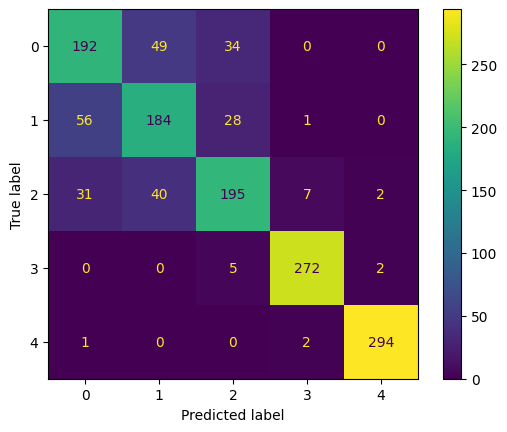

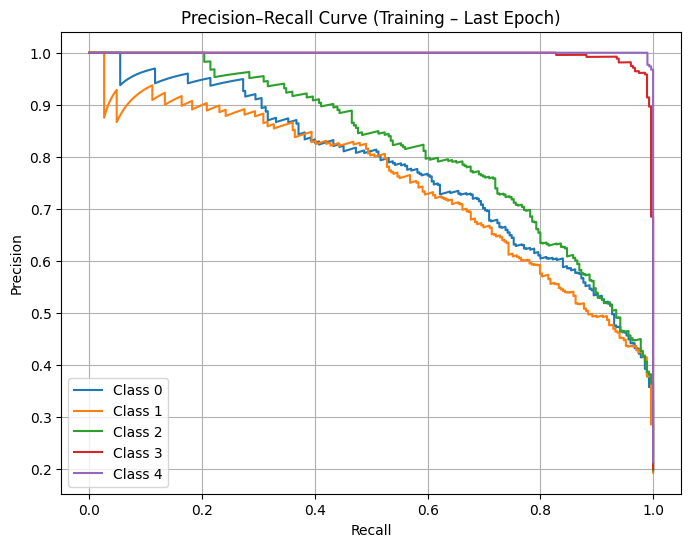

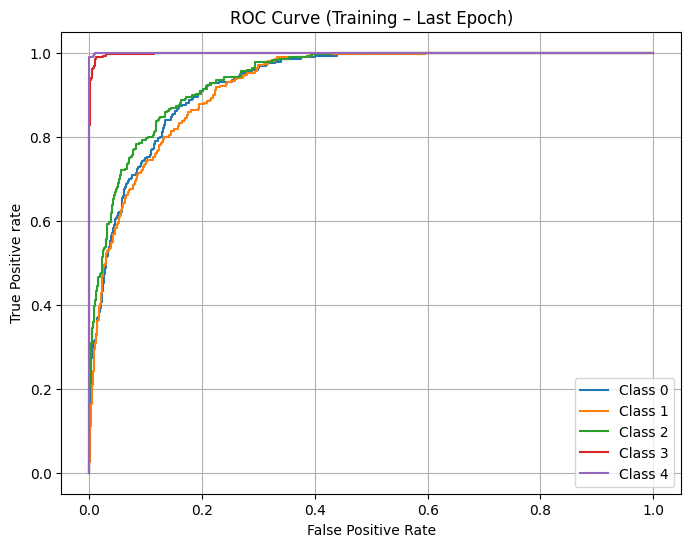

Test Accuracy: 63.04%, Recall: 0.43, Precision: 0.53, Specificity: 0.88, F1-Score: 0.46
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.81      0.79       204
           1       0.27      0.33      0.30        54
           2       0.52      0.42      0.46        69
           3       0.58      0.47      0.52        15
           4       0.50      0.14      0.22         7

    accuracy                           0.63       349
   macro avg       0.53      0.43      0.46       349
weighted avg       0.63      0.63      0.63       349



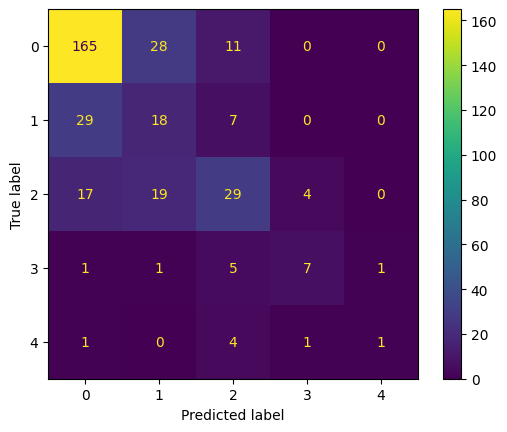

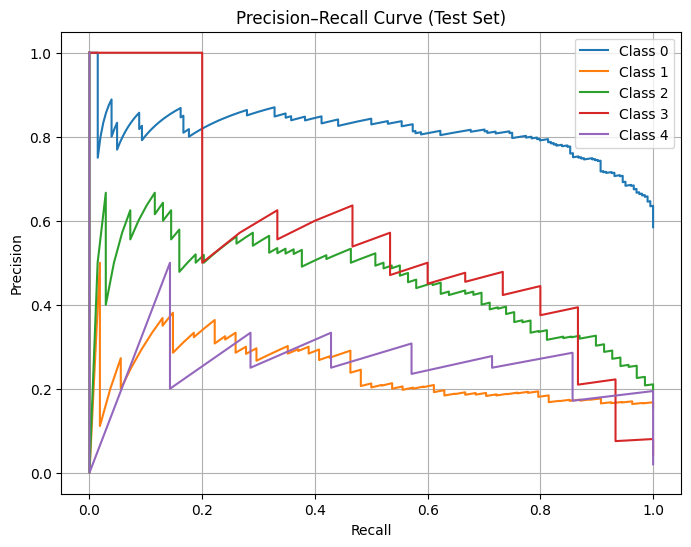

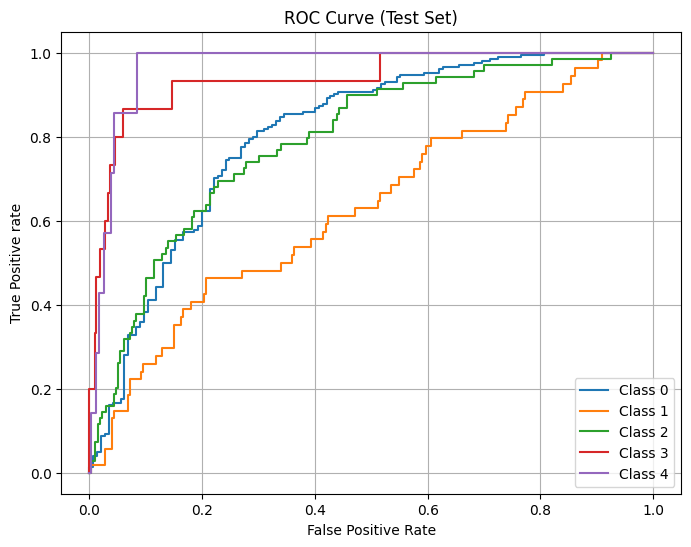

In [4]:
#Improved data augmentation

import torch
import torchvision.transforms as transforms
from torchvision.transforms import v2
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision, MulticlassSpecificity, MulticlassF1Score
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
from collections import Counter

# Image transformer

train_transform = v2.Compose([
    v2.Resize(256),
    v2.RandomResizedCrop(
        size=224,
        scale=(0.8, 1.0),
        ratio=(0.9, 1.1)
    ),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(15),
    v2.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.2,
        hue=0.02
    ),
    v2.GaussianBlur(
        kernel_size=3,
        sigma=(0.1, 2.0)
    ),
    v2.ToImage(),
    v2.ToDtype(
        torch.float32,
        scale=True
    ),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
    v2.RandomErasing(
        p=0.25,
        scale=(0.02, 0.1),
        ratio=(0.3, 3.3),
        value='random'
    )
])

test_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Creates a custom dataset. Initialised with the csv file, image file and transformeded.

class messidorDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = Image.open(img_path).convert("RGB")
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

# Get the images and csv data file

annotations_file = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor_data.csv"
img_dir = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor-2/preprocess"
af = pd.read_csv(annotations_file)
num_imgs = len(af)
label = af.iloc[:, 1].values
indices = np.arange(len(af))

# Splits the dataset into training and testing sets in 80:20 ratio respectively

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(sss.split(indices, label))

training_dataset = messidorDataset(annotations_file, img_dir, train_transform)
testing_dataset = messidorDataset(annotations_file, img_dir, test_transform)

train_dataset = Subset(training_dataset, train_index)
test_dataset = Subset(testing_dataset, test_index)

targets = training_dataset.img_labels.iloc[train_dataset.indices, 1].values
num_samples = len(targets)
class_counts = torch.bincount(torch.tensor(targets))
sample_weights = torch.tensor([1.0 / class_counts[t] for t in targets])
train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

labels = testing_dataset.img_labels.iloc[test_dataset.indices, 1].values
unique, counts = np.unique(labels, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Class {u}: {c}")

# Loads the dataset, batchsize and shuffles the dataset

train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_counter = Counter()

for inputs, labels in train_loader:
    class_counter.update(labels.tolist())

print("Sampled class counts in one epoch:")
for cls in sorted(class_counter.keys()):
    print(f"Class {cls}: {class_counter[cls]}")

# Load ResNet18

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# This replaces the final layer of the model to output 5 classes instead of 1000

model.fc = torch.nn.Linear(
    in_features=model.fc.in_features,
    out_features=5
)

# Freeze all layers except the last two layers.

for param in model.parameters():
    param.requires_grad = False
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Uses cuda if available or it uses cpu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss function and optimizer

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {"params": model.layer3.parameters(), "lr": 1e-4},
    {"params": model.layer4.parameters(), "lr": 1e-4},
    {"params": model.fc.parameters(), "lr": 1e-3},
])

# Model training

total_epoch = 10
recall_macro = MulticlassRecall(num_classes=5, average="macro").to(device)
precision_macro = MulticlassPrecision(num_classes=5, average="macro").to(device)
specificity_macro = MulticlassSpecificity(num_classes=5, average="macro").to(device)
f1score_macro = MulticlassF1Score(num_classes=5, average="macro").to(device)
train_probs = []
pred_val = []
all_labels = []
for epoch in range(total_epoch):
    model.train()
    recall_macro.reset()
    precision_macro.reset()
    specificity_macro.reset()
    f1score_macro.reset()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        if epoch == total_epoch-1:
            probs = torch.softmax(outputs, dim=1)
            train_probs.append(probs.detach().numpy())
            pred_val.append(predicted.detach().numpy())
            all_labels.append(labels.detach().numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)

    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
    print(f'Epoch [{epoch+1}/{total_epoch}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
train_probs = np.concatenate(train_probs, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
recall_macro.reset()
precision_macro.reset()
specificity_macro.reset()
f1score_macro.reset()
correct = 0
total = 0
test_probs = []
pred_val = []
all_labels = []

# Model testing

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        probs = torch.softmax(outputs, dim=1)
        test_probs.append(probs.numpy())
        pred_val.append(predicted.numpy())
        all_labels.append(labels.numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)
    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
test_probs = np.concatenate(test_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))

for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()



Class 0: 204
Class 1: 54
Class 2: 69
Class 3: 15
Class 4: 7
Sampled class counts in one epoch:
Class 0: 272
Class 1: 286
Class 2: 247
Class 3: 324
Class 4: 266
Epoch [1/10], Loss: 1.3527, Accuracy: 44.37%, Recall: 0.44, Precision: 0.44, Specificity: 0.86, F1-Score: 0.44
Epoch [2/10], Loss: 1.0960, Accuracy: 61.94%, Recall: 0.62, Precision: 0.62, Specificity: 0.90, F1-Score: 0.62
Epoch [3/10], Loss: 0.9823, Accuracy: 68.60%, Recall: 0.69, Precision: 0.68, Specificity: 0.92, F1-Score: 0.68
Epoch [4/10], Loss: 0.9234, Accuracy: 71.47%, Recall: 0.71, Precision: 0.71, Specificity: 0.93, F1-Score: 0.71
Epoch [5/10], Loss: 0.8932, Accuracy: 71.97%, Recall: 0.72, Precision: 0.72, Specificity: 0.93, F1-Score: 0.72
Epoch [6/10], Loss: 0.8526, Accuracy: 75.99%, Recall: 0.76, Precision: 0.76, Specificity: 0.94, F1-Score: 0.76
Epoch [7/10], Loss: 0.8337, Accuracy: 77.20%, Recall: 0.77, Precision: 0.77, Specificity: 0.94, F1-Score: 0.77
Epoch [8/10], Loss: 0.7941, Accuracy: 78.21%, Recall: 0.78, Pre

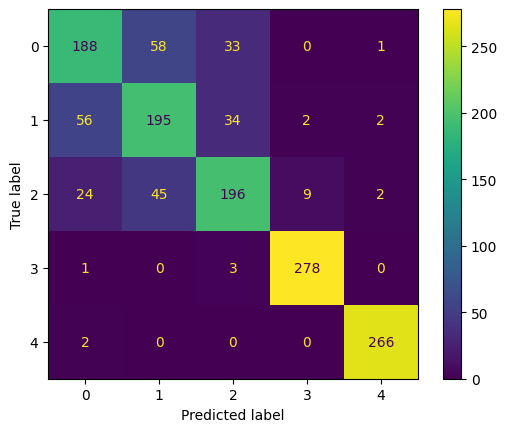

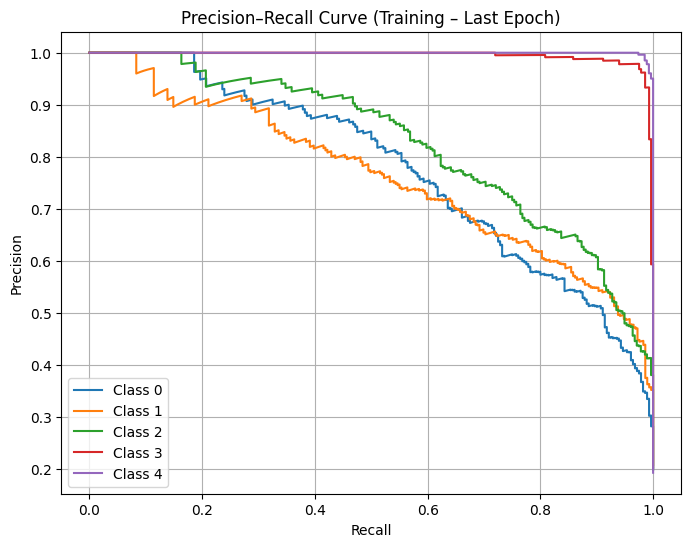

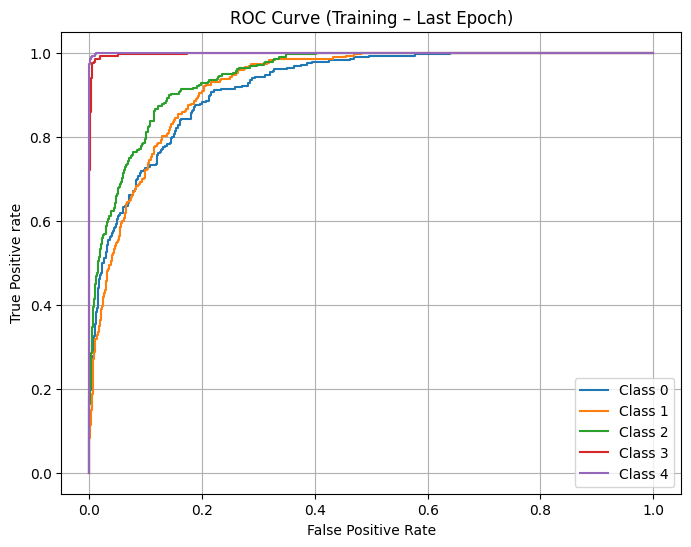

Test Accuracy: 60.46%, Recall: 0.41, Precision: 0.54, Specificity: 0.88, F1-Score: 0.43
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.74      0.77       204
           1       0.31      0.20      0.24        54
           2       0.37      0.64      0.47        69
           3       0.71      0.33      0.45        15
           4       0.50      0.14      0.22         7

    accuracy                           0.60       349
   macro avg       0.54      0.41      0.43       349
weighted avg       0.64      0.60      0.61       349



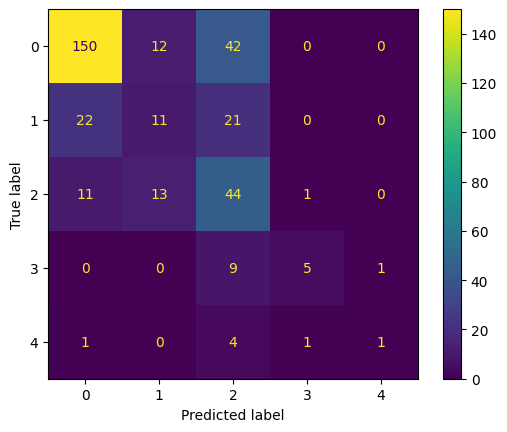

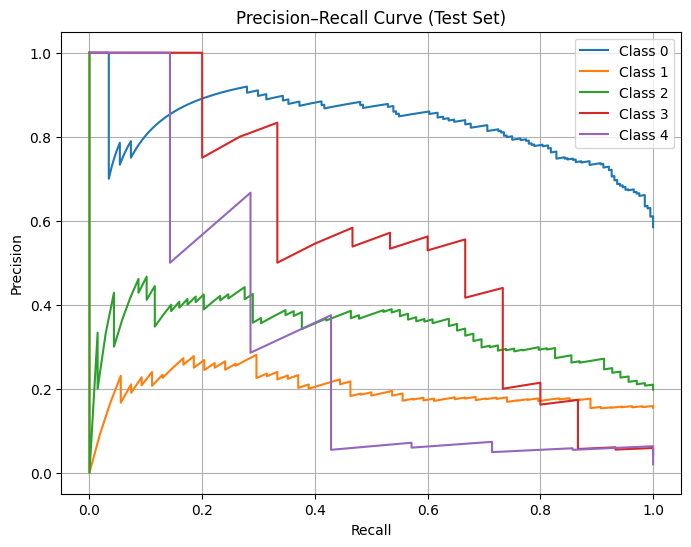

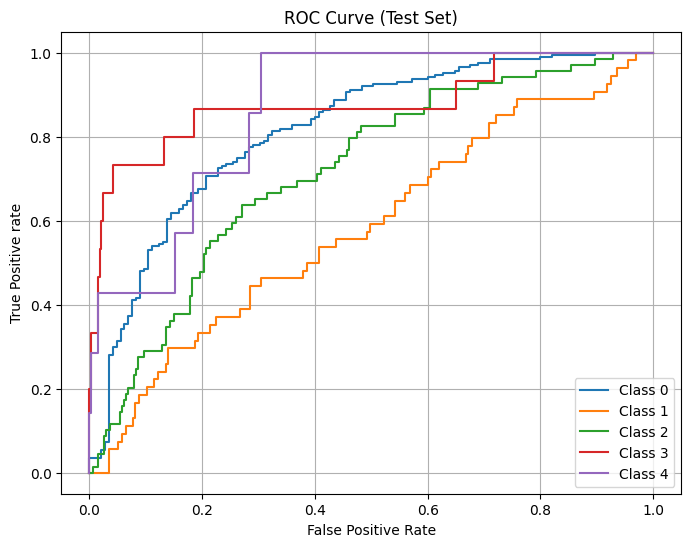

In [6]:
#Improved data augmentation and Label smoothing

import torch
import torchvision.transforms as transforms
from torchvision.transforms import v2
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision, MulticlassSpecificity, MulticlassF1Score
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
from collections import Counter

# Image transformer

train_transform = v2.Compose([
    v2.Resize(256),
    v2.RandomResizedCrop(
        size=224,
        scale=(0.8, 1.0),
        ratio=(0.9, 1.1)
    ),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(15),
    v2.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.2,
        hue=0.02
    ),
    v2.GaussianBlur(
        kernel_size=3,
        sigma=(0.1, 2.0)
    ),
    v2.ToImage(),
    v2.ToDtype(
        torch.float32,
        scale=True
    ),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
    v2.RandomErasing(
        p=0.25,
        scale=(0.02, 0.1),
        ratio=(0.3, 3.3),
        value='random'
    )
])

test_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Creates a custom dataset. Initialised with the csv file, image file and transformeded.

class messidorDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = Image.open(img_path).convert("RGB")
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

# Get the images and csv data file

annotations_file = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor_data.csv"
img_dir = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor-2/preprocess"
af = pd.read_csv(annotations_file)
num_imgs = len(af)
label = af.iloc[:, 1].values
indices = np.arange(len(af))

# Splits the dataset into training and testing sets in 80:20 ratio respectively

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(sss.split(indices, label))

training_dataset = messidorDataset(annotations_file, img_dir, train_transform)
testing_dataset = messidorDataset(annotations_file, img_dir, test_transform)

train_dataset = Subset(training_dataset, train_index)
test_dataset = Subset(testing_dataset, test_index)

targets = training_dataset.img_labels.iloc[train_dataset.indices, 1].values
num_samples = len(targets)
class_counts = torch.bincount(torch.tensor(targets))
sample_weights = torch.tensor([1.0 / class_counts[t] for t in targets])
train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

labels = testing_dataset.img_labels.iloc[test_dataset.indices, 1].values
unique, counts = np.unique(labels, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Class {u}: {c}")

# Loads the dataset, batchsize and shuffles the dataset

train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_counter = Counter()

for inputs, labels in train_loader:
    class_counter.update(labels.tolist())

print("Sampled class counts in one epoch:")
for cls in sorted(class_counter.keys()):
    print(f"Class {cls}: {class_counter[cls]}")

# Load ResNet18

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# This replaces the final layer of the model to output 5 classes instead of 1000

model.fc = torch.nn.Linear(
    in_features=model.fc.in_features,
    out_features=5
)

# Freeze all layers except the last two layers.

for param in model.parameters():
    param.requires_grad = False
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Uses cuda if available or it uses cpu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss function and optimizer

criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam([
    {"params": model.layer3.parameters(), "lr": 1e-4},
    {"params": model.layer4.parameters(), "lr": 1e-4},
    {"params": model.fc.parameters(), "lr": 1e-3},
])

# Model training

total_epoch = 10
recall_macro = MulticlassRecall(num_classes=5, average="macro").to(device)
precision_macro = MulticlassPrecision(num_classes=5, average="macro").to(device)
specificity_macro = MulticlassSpecificity(num_classes=5, average="macro").to(device)
f1score_macro = MulticlassF1Score(num_classes=5, average="macro").to(device)
train_probs = []
pred_val = []
all_labels = []
for epoch in range(total_epoch):
    model.train()
    recall_macro.reset()
    precision_macro.reset()
    specificity_macro.reset()
    f1score_macro.reset()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        if epoch == total_epoch-1:
            probs = torch.softmax(outputs, dim=1)
            train_probs.append(probs.detach().numpy())
            pred_val.append(predicted.detach().numpy())
            all_labels.append(labels.detach().numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)

    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
    print(f'Epoch [{epoch+1}/{total_epoch}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
train_probs = np.concatenate(train_probs, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
recall_macro.reset()
precision_macro.reset()
specificity_macro.reset()
f1score_macro.reset()
correct = 0
total = 0
test_probs = []
pred_val = []
all_labels = []

# Model testing

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        probs = torch.softmax(outputs, dim=1)
        test_probs.append(probs.numpy())
        pred_val.append(predicted.numpy())
        all_labels.append(labels.numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)
    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
test_probs = np.concatenate(test_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))

for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()



Class 0: 204
Class 1: 54
Class 2: 69
Class 3: 15
Class 4: 7
Sampled class counts in one epoch:
Class 0: 263
Class 1: 274
Class 2: 280
Class 3: 286
Class 4: 292
Epoch [1/10], Loss: 1.4776, Accuracy: 36.63%, Recall: 0.36, Precision: 0.35, Specificity: 0.84, F1-Score: 0.36
Epoch [2/10], Loss: 1.2117, Accuracy: 52.19%, Recall: 0.52, Precision: 0.51, Specificity: 0.88, F1-Score: 0.51
Epoch [3/10], Loss: 1.0791, Accuracy: 59.50%, Recall: 0.59, Precision: 0.58, Specificity: 0.90, F1-Score: 0.58
Epoch [4/10], Loss: 1.0153, Accuracy: 64.87%, Recall: 0.65, Precision: 0.65, Specificity: 0.91, F1-Score: 0.65
Epoch [5/10], Loss: 0.9882, Accuracy: 66.59%, Recall: 0.67, Precision: 0.66, Specificity: 0.92, F1-Score: 0.66
Epoch [6/10], Loss: 0.9483, Accuracy: 67.67%, Recall: 0.68, Precision: 0.68, Specificity: 0.92, F1-Score: 0.68
Epoch [7/10], Loss: 0.9200, Accuracy: 70.04%, Recall: 0.71, Precision: 0.70, Specificity: 0.92, F1-Score: 0.71
Epoch [8/10], Loss: 0.8629, Accuracy: 74.12%, Recall: 0.73, Pre

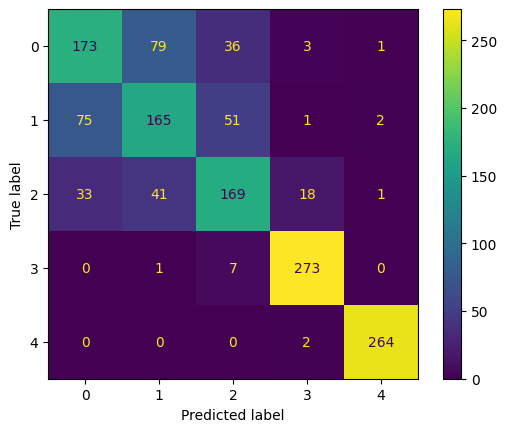

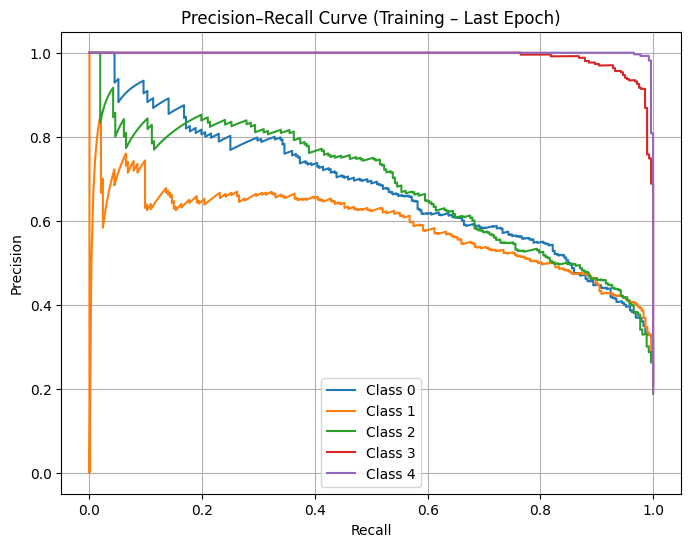

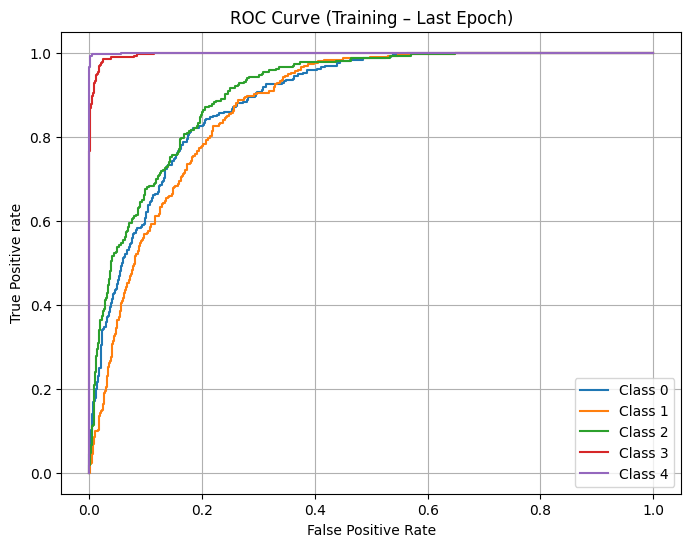

Test Accuracy: 54.15%, Recall: 0.43, Precision: 0.41, Specificity: 0.87, F1-Score: 0.41
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.59      0.69       204
           1       0.24      0.54      0.33        54
           2       0.48      0.43      0.46        69
           3       0.53      0.60      0.56        15
           4       0.00      0.00      0.00         7

    accuracy                           0.54       349
   macro avg       0.41      0.43      0.41       349
weighted avg       0.64      0.54      0.57       349



/home/matth/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/matth/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/matth/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

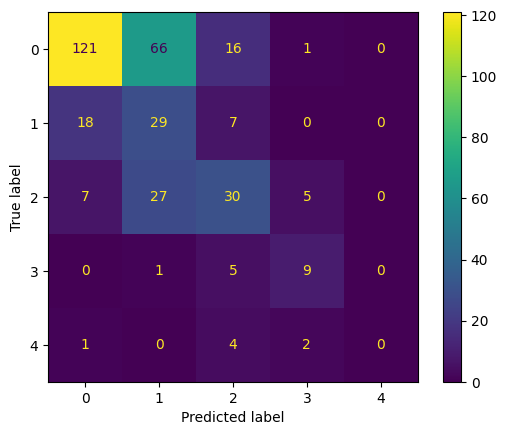

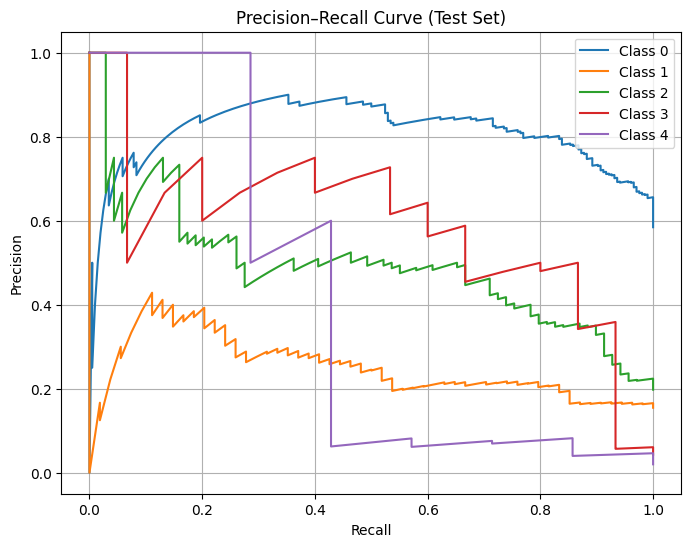

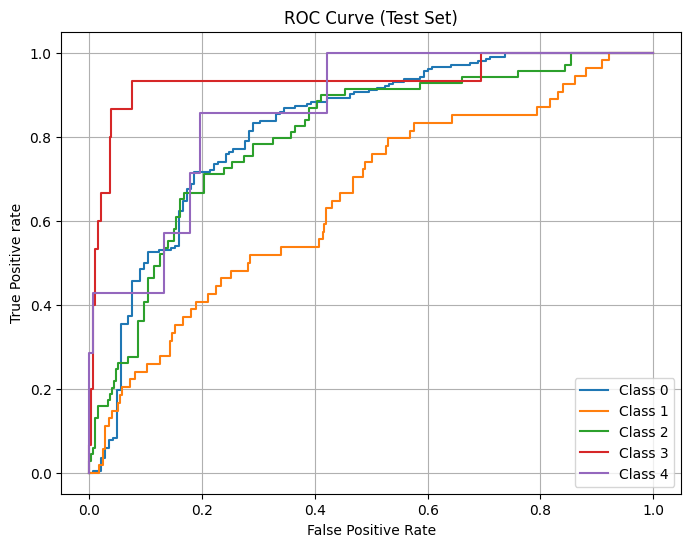

In [ ]:
#Improved data augmentation, Label smoothing, dropout and feature reduction

import torch
from torch import nn
import torchvision.transforms as transforms
from torchvision.transforms import v2
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision, MulticlassSpecificity, MulticlassF1Score
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
from collections import Counter

# Image transformer

train_transform = v2.Compose([
    v2.Resize(256),
    v2.RandomResizedCrop(
        size=224,
        scale=(0.8, 1.0),
        ratio=(0.9, 1.1)
    ),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(15),
    v2.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.2,
        hue=0.02
    ),
    v2.GaussianBlur(
        kernel_size=3,
        sigma=(0.1, 2.0)
    ),
    v2.ToImage(),
    v2.ToDtype(
        torch.float32,
        scale=True
    ),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
    v2.RandomErasing(
        p=0.25,
        scale=(0.02, 0.1),
        ratio=(0.3, 3.3),
        value='random'
    )
])

test_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Creates a custom dataset. Initialised with the csv file, image file and transformeded.

class messidorDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = Image.open(img_path).convert("RGB")
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

# Get the images and csv data file

annotations_file = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor_data.csv"
img_dir = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor-2/preprocess"
af = pd.read_csv(annotations_file)
num_imgs = len(af)
label = af.iloc[:, 1].values
indices = np.arange(len(af))

# Splits the dataset into training and testing sets in 80:20 ratio respectively

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(sss.split(indices, label))

training_dataset = messidorDataset(annotations_file, img_dir, train_transform)
testing_dataset = messidorDataset(annotations_file, img_dir, test_transform)

train_dataset = Subset(training_dataset, train_index)
test_dataset = Subset(testing_dataset, test_index)

targets = training_dataset.img_labels.iloc[train_dataset.indices, 1].values
num_samples = len(targets)
class_counts = torch.bincount(torch.tensor(targets))
sample_weights = torch.tensor([1.0 / class_counts[t] for t in targets])
train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

labels = testing_dataset.img_labels.iloc[test_dataset.indices, 1].values
unique, counts = np.unique(labels, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Class {u}: {c}")

# Loads the dataset, batchsize and shuffles the dataset

train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_counter = Counter()

for inputs, labels in train_loader:
    class_counter.update(labels.tolist())

print("Sampled class counts in one epoch:")
for cls in sorted(class_counter.keys()):
    print(f"Class {cls}: {class_counter[cls]}")

# Load ResNet18

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# This replaces the final layer of the model to output 5 classes instead of 1000

model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 5)
)

# Freeze all layers except the last two layers.

for param in model.parameters():
    param.requires_grad = False
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Uses cuda if available or it uses cpu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss function and optimizer

criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam([
    {"params": model.layer3.parameters(), "lr": 1e-4},
    {"params": model.layer4.parameters(), "lr": 1e-4},
    {"params": model.fc.parameters(), "lr": 1e-3},
])

# Model training

total_epoch = 10
recall_macro = MulticlassRecall(num_classes=5, average="macro").to(device)
precision_macro = MulticlassPrecision(num_classes=5, average="macro").to(device)
specificity_macro = MulticlassSpecificity(num_classes=5, average="macro").to(device)
f1score_macro = MulticlassF1Score(num_classes=5, average="macro").to(device)
train_probs = []
pred_val = []
all_labels = []
for epoch in range(total_epoch):
    model.train()
    recall_macro.reset()
    precision_macro.reset()
    specificity_macro.reset()
    f1score_macro.reset()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        if epoch == total_epoch-1:
            probs = torch.softmax(outputs, dim=1)
            train_probs.append(probs.detach().numpy())
            pred_val.append(predicted.detach().numpy())
            all_labels.append(labels.detach().numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)

    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
    print(f'Epoch [{epoch+1}/{total_epoch}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
train_probs = np.concatenate(train_probs, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
recall_macro.reset()
precision_macro.reset()
specificity_macro.reset()
f1score_macro.reset()
correct = 0
total = 0
test_probs = []
pred_val = []
all_labels = []

# Model testing

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        probs = torch.softmax(outputs, dim=1)
        test_probs.append(probs.numpy())
        pred_val.append(predicted.numpy())
        all_labels.append(labels.numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)
    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
test_probs = np.concatenate(test_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))

for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()



Class 0: 204
Class 1: 54
Class 2: 69
Class 3: 15
Class 4: 7
Sampled class counts in one epoch:
Class 0: 295
Class 1: 279
Class 2: 275
Class 3: 265
Class 4: 281
Epoch [1/10], Loss: 1.5388, Accuracy: 31.90%, Recall: 0.32, Precision: 0.31, Specificity: 0.83, F1-Score: 0.31
Epoch [2/10], Loss: 1.2389, Accuracy: 49.32%, Recall: 0.49, Precision: 0.49, Specificity: 0.87, F1-Score: 0.49
Epoch [3/10], Loss: 1.1493, Accuracy: 56.06%, Recall: 0.56, Precision: 0.55, Specificity: 0.89, F1-Score: 0.55
Epoch [4/10], Loss: 1.0541, Accuracy: 60.00%, Recall: 0.60, Precision: 0.59, Specificity: 0.90, F1-Score: 0.59
Epoch [5/10], Loss: 1.0140, Accuracy: 66.09%, Recall: 0.65, Precision: 0.64, Specificity: 0.92, F1-Score: 0.64
Epoch [6/10], Loss: 0.9582, Accuracy: 69.10%, Recall: 0.68, Precision: 0.67, Specificity: 0.92, F1-Score: 0.67
Epoch [7/10], Loss: 0.9388, Accuracy: 70.11%, Recall: 0.69, Precision: 0.68, Specificity: 0.93, F1-Score: 0.68
Epoch [8/10], Loss: 0.9431, Accuracy: 69.53%, Recall: 0.70, Pre

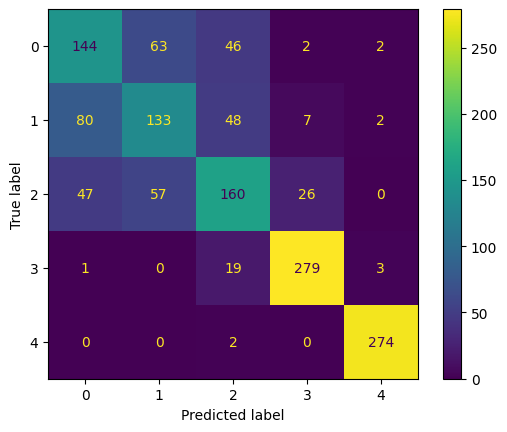

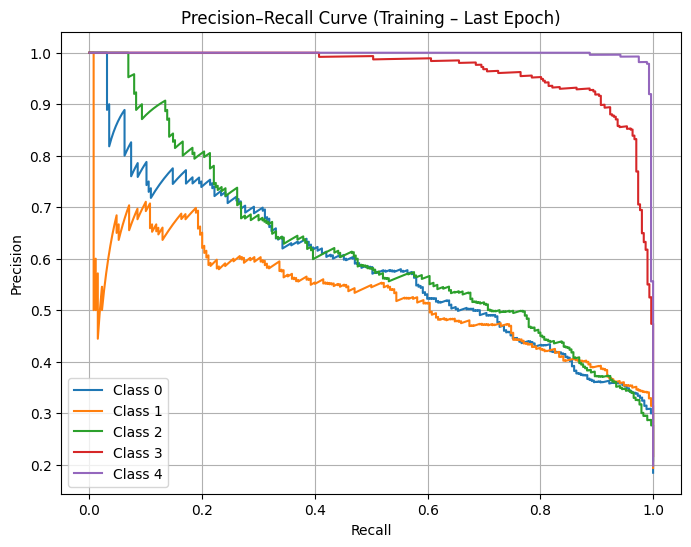

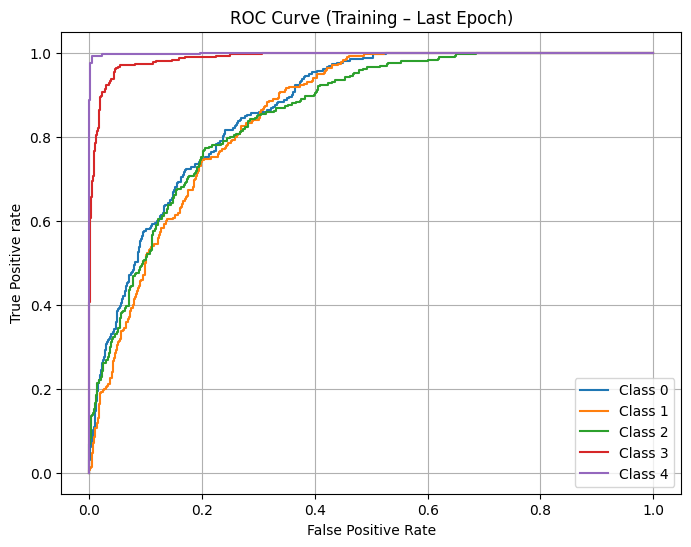

Test Accuracy: 60.17%, Recall: 0.39, Precision: 0.42, Specificity: 0.86, F1-Score: 0.40
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.78      0.75       204
           1       0.29      0.35      0.32        54
           2       0.46      0.36      0.41        69
           3       0.64      0.47      0.54        15
           4       0.00      0.00      0.00         7

    accuracy                           0.60       349
   macro avg       0.42      0.39      0.40       349
weighted avg       0.59      0.60      0.59       349



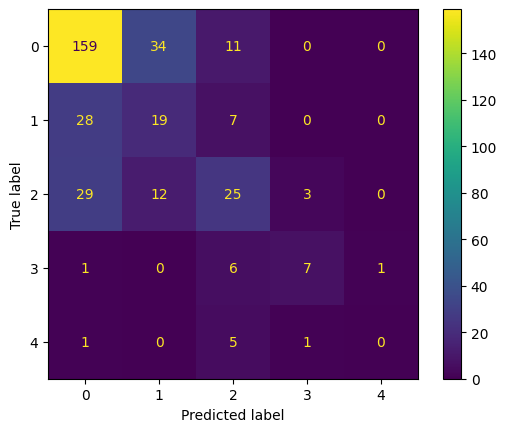

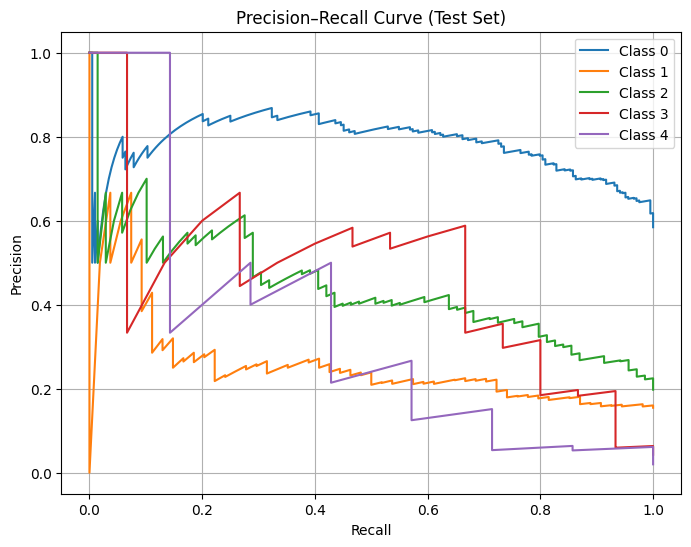

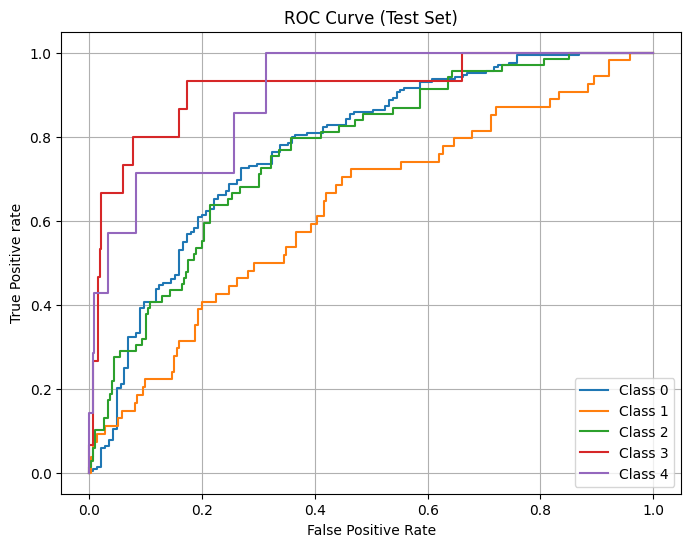

In [8]:
#Improved data augmentation, Label smoothing, dropout and feature reduction
#Only fine-tuning last layer and claassifier

import torch
from torch import nn
import torchvision.transforms as transforms
from torchvision.transforms import v2
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision, MulticlassSpecificity, MulticlassF1Score
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
from collections import Counter

# Image transformer

train_transform = v2.Compose([
    v2.Resize(256),
    v2.RandomResizedCrop(
        size=224,
        scale=(0.8, 1.0),
        ratio=(0.9, 1.1)
    ),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(15),
    v2.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.2,
        hue=0.02
    ),
    v2.GaussianBlur(
        kernel_size=3,
        sigma=(0.1, 2.0)
    ),
    v2.ToImage(),
    v2.ToDtype(
        torch.float32,
        scale=True
    ),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
    v2.RandomErasing(
        p=0.25,
        scale=(0.02, 0.1),
        ratio=(0.3, 3.3),
        value='random'
    )
])

test_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Creates a custom dataset. Initialised with the csv file, image file and transformeded.

class messidorDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = Image.open(img_path).convert("RGB")
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

# Get the images and csv data file

annotations_file = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor_data.csv"
img_dir = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor-2/preprocess"
af = pd.read_csv(annotations_file)
num_imgs = len(af)
label = af.iloc[:, 1].values
indices = np.arange(len(af))

# Splits the dataset into training and testing sets in 80:20 ratio respectively

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(sss.split(indices, label))

training_dataset = messidorDataset(annotations_file, img_dir, train_transform)
testing_dataset = messidorDataset(annotations_file, img_dir, test_transform)

train_dataset = Subset(training_dataset, train_index)
test_dataset = Subset(testing_dataset, test_index)

targets = training_dataset.img_labels.iloc[train_dataset.indices, 1].values
num_samples = len(targets)
class_counts = torch.bincount(torch.tensor(targets))
sample_weights = torch.tensor([1.0 / class_counts[t] for t in targets])
train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

labels = testing_dataset.img_labels.iloc[test_dataset.indices, 1].values
unique, counts = np.unique(labels, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Class {u}: {c}")

# Loads the dataset, batchsize and shuffles the dataset

train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_counter = Counter()

for inputs, labels in train_loader:
    class_counter.update(labels.tolist())

print("Sampled class counts in one epoch:")
for cls in sorted(class_counter.keys()):
    print(f"Class {cls}: {class_counter[cls]}")

# Load ResNet18

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# This replaces the final layer of the model to output 5 classes instead of 1000

model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 5)
)

# Freeze all layers except the last two layers.

for param in model.parameters():
    param.requires_grad = False
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Uses cuda if available or it uses cpu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss function and optimizer

criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam([
    {"params": model.layer4.parameters(), "lr": 1e-4},
    {"params": model.fc.parameters(), "lr": 1e-3},
])

# Model training

total_epoch = 10
recall_macro = MulticlassRecall(num_classes=5, average="macro").to(device)
precision_macro = MulticlassPrecision(num_classes=5, average="macro").to(device)
specificity_macro = MulticlassSpecificity(num_classes=5, average="macro").to(device)
f1score_macro = MulticlassF1Score(num_classes=5, average="macro").to(device)
train_probs = []
pred_val = []
all_labels = []
for epoch in range(total_epoch):
    model.train()
    recall_macro.reset()
    precision_macro.reset()
    specificity_macro.reset()
    f1score_macro.reset()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        if epoch == total_epoch-1:
            probs = torch.softmax(outputs, dim=1)
            train_probs.append(probs.detach().numpy())
            pred_val.append(predicted.detach().numpy())
            all_labels.append(labels.detach().numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)

    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
    print(f'Epoch [{epoch+1}/{total_epoch}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
train_probs = np.concatenate(train_probs, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
recall_macro.reset()
precision_macro.reset()
specificity_macro.reset()
f1score_macro.reset()
correct = 0
total = 0
test_probs = []
pred_val = []
all_labels = []

# Model testing

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        probs = torch.softmax(outputs, dim=1)
        test_probs.append(probs.numpy())
        pred_val.append(predicted.numpy())
        all_labels.append(labels.numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)
    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
test_probs = np.concatenate(test_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))

for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()



Class 0: 204
Class 1: 54
Class 2: 69
Class 3: 15
Class 4: 7
Sampled class counts in one epoch:
Class 0: 257
Class 1: 293
Class 2: 283
Class 3: 293
Class 4: 269
Epoch [1/14], Loss: 1.5201, Accuracy: 30.18%, Recall: 0.30, Precision: 0.30, Specificity: 0.83, F1-Score: 0.30
Epoch [2/14], Loss: 1.3262, Accuracy: 46.45%, Recall: 0.46, Precision: 0.45, Specificity: 0.87, F1-Score: 0.45
Epoch [3/14], Loss: 1.2482, Accuracy: 51.47%, Recall: 0.51, Precision: 0.51, Specificity: 0.88, F1-Score: 0.51
Epoch [4/14], Loss: 1.1770, Accuracy: 55.20%, Recall: 0.55, Precision: 0.54, Specificity: 0.89, F1-Score: 0.54
Epoch [5/14], Loss: 1.1728, Accuracy: 54.27%, Recall: 0.54, Precision: 0.54, Specificity: 0.89, F1-Score: 0.53
Epoch [6/14], Loss: 1.1154, Accuracy: 59.50%, Recall: 0.59, Precision: 0.58, Specificity: 0.90, F1-Score: 0.58
Epoch [7/14], Loss: 1.0754, Accuracy: 60.50%, Recall: 0.61, Precision: 0.60, Specificity: 0.90, F1-Score: 0.60
Epoch [8/14], Loss: 1.0550, Accuracy: 62.51%, Recall: 0.61, Pre

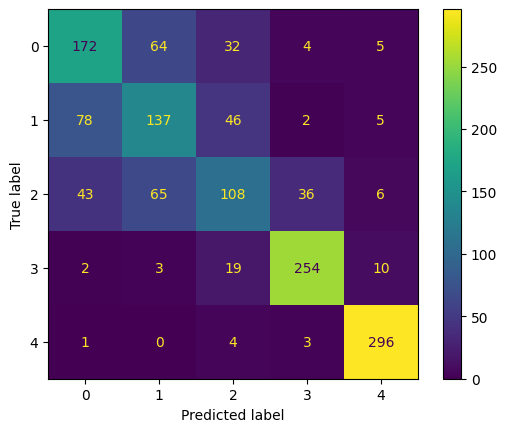

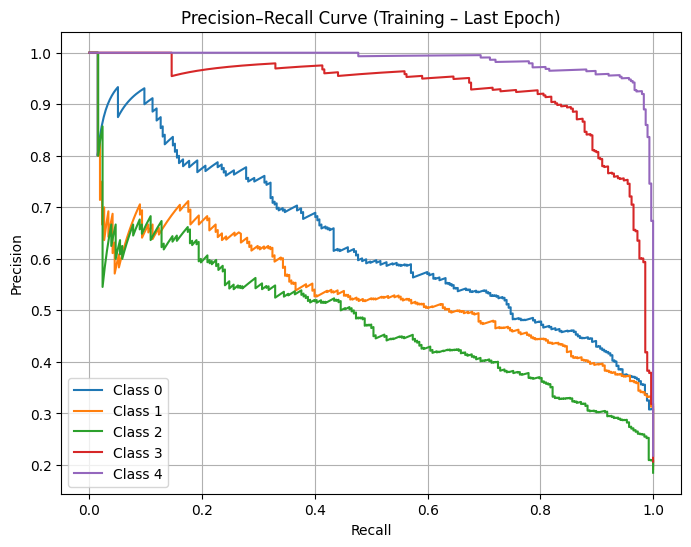

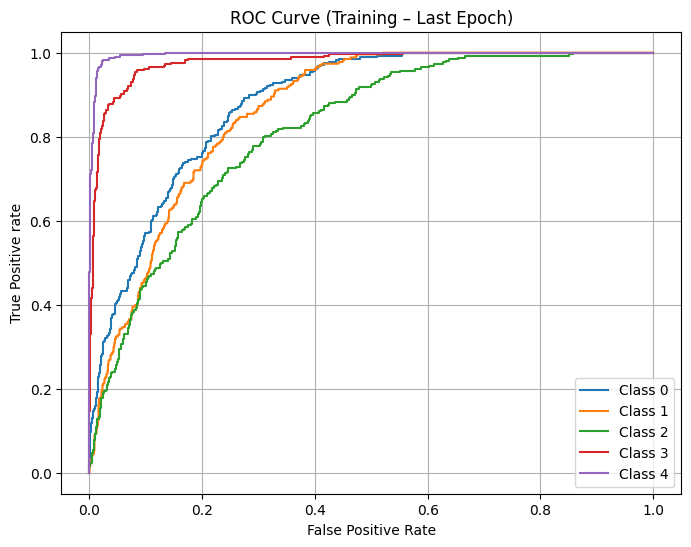

Test Accuracy: 53.87%, Recall: 0.42, Precision: 0.47, Specificity: 0.86, F1-Score: 0.42
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.67      0.71       204
           1       0.25      0.54      0.34        54
           2       0.47      0.22      0.30        69
           3       0.35      0.40      0.38        15
           4       0.50      0.29      0.36         7

    accuracy                           0.54       349
   macro avg       0.47      0.42      0.42       349
weighted avg       0.60      0.54      0.55       349



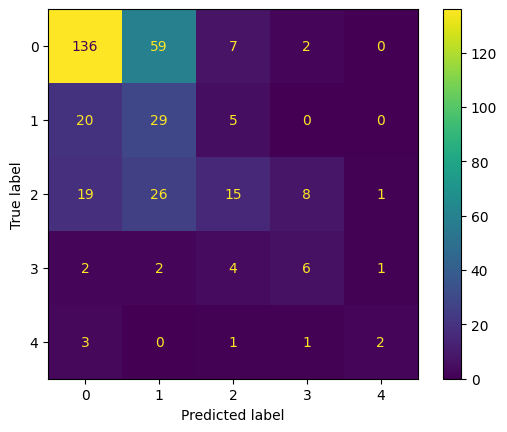

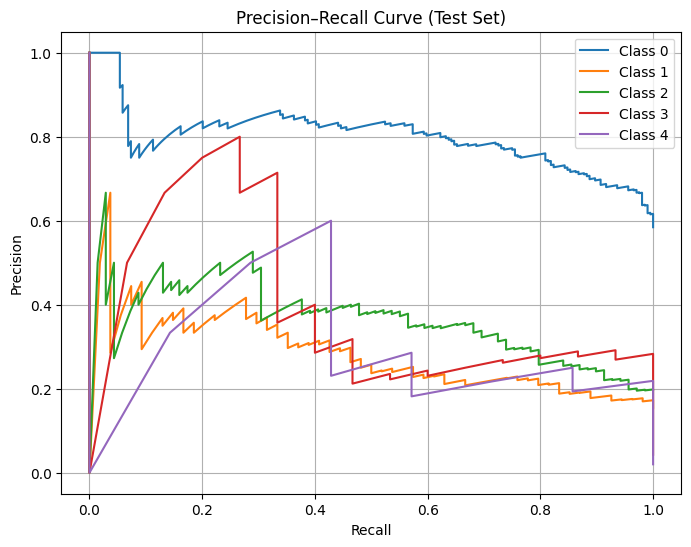

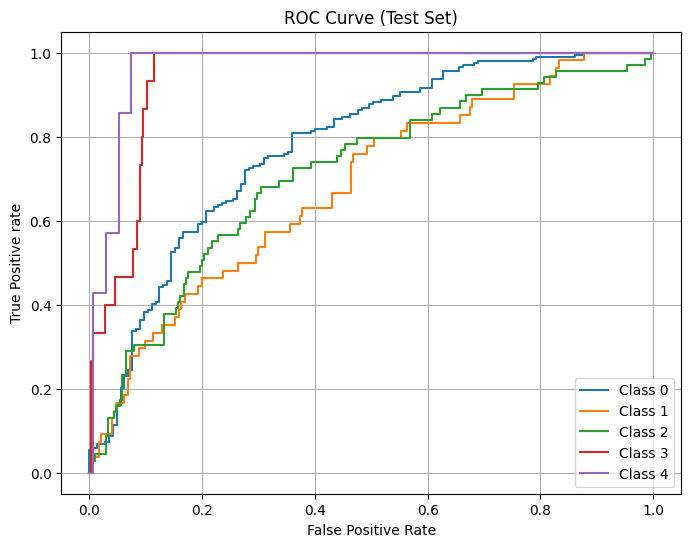

In [1]:
#Improved data augmentation, Label smoothing, dropout and feature reduction
#Only fine-tuning last layer and claassifier

import torch
from torch import nn
import torchvision.transforms as transforms
from torchvision.transforms import v2
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision, MulticlassSpecificity, MulticlassF1Score
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
from collections import Counter

# Image transformer

train_transform = v2.Compose([
    v2.Resize(256),
    v2.RandomResizedCrop(
        size=224,
        scale=(0.8, 1.0),
        ratio=(0.9, 1.1)
    ),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(15),
    v2.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.2,
        hue=0.02
    ),
    v2.GaussianBlur(
        kernel_size=3,
        sigma=(0.1, 2.0)
    ),
    v2.ToImage(),
    v2.ToDtype(
        torch.float32,
        scale=True
    ),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
    v2.RandomErasing(
        p=0.25,
        scale=(0.02, 0.1),
        ratio=(0.3, 3.3),
        value='random'
    )
])

test_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Creates a custom dataset. Initialised with the csv file, image file and transformeded.

class messidorDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = Image.open(img_path).convert("RGB")
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

# Get the images and csv data file

annotations_file = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor_data.csv"
img_dir = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor-2/preprocess"
af = pd.read_csv(annotations_file)
num_imgs = len(af)
label = af.iloc[:, 1].values
indices = np.arange(len(af))

# Splits the dataset into training and testing sets in 80:20 ratio respectively

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(sss.split(indices, label))

training_dataset = messidorDataset(annotations_file, img_dir, train_transform)
testing_dataset = messidorDataset(annotations_file, img_dir, test_transform)

train_dataset = Subset(training_dataset, train_index)
test_dataset = Subset(testing_dataset, test_index)

targets = training_dataset.img_labels.iloc[train_dataset.indices, 1].values
num_samples = len(targets)
class_counts = torch.bincount(torch.tensor(targets))
sample_weights = torch.tensor([1.0 / class_counts[t] for t in targets])
train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

labels = testing_dataset.img_labels.iloc[test_dataset.indices, 1].values
unique, counts = np.unique(labels, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Class {u}: {c}")

# Loads the dataset, batchsize and shuffles the dataset

train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_counter = Counter()

for inputs, labels in train_loader:
    class_counter.update(labels.tolist())

print("Sampled class counts in one epoch:")
for cls in sorted(class_counter.keys()):
    print(f"Class {cls}: {class_counter[cls]}")

# Load ResNet18

model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V2)

# This replaces the final layer of the model to output 5 classes instead of 1000

model.classifier[-1] = nn.Sequential(
    nn.Linear(1280, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 5)
)

# Freeze all layers except the last two layers.

for param in model.parameters():
    param.requires_grad = False
for param in model.features[-3].parameters():
    param.requires_grad = True
for param in model.features[-2].parameters():
    param.requires_grad = True
for param in model.features[-1].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True

# Uses cuda if available or it uses cpu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss function and optimizer

criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam([
    {"params": model.features[-3].parameters(), "lr": 1e-4},
    {"params": model.features[-2].parameters(), "lr": 1e-4},
    {"params": model.features[-1].parameters(), "lr": 1e-4},
    {"params": model.classifier[-1].parameters(), "lr": 1e-3},
])

# Model training

total_epoch = 14
recall_macro = MulticlassRecall(num_classes=5, average="macro").to(device)
precision_macro = MulticlassPrecision(num_classes=5, average="macro").to(device)
specificity_macro = MulticlassSpecificity(num_classes=5, average="macro").to(device)
f1score_macro = MulticlassF1Score(num_classes=5, average="macro").to(device)
train_probs = []
pred_val = []
all_labels = []
for epoch in range(total_epoch):
    model.train()
    recall_macro.reset()
    precision_macro.reset()
    specificity_macro.reset()
    f1score_macro.reset()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        if epoch == total_epoch-1:
            probs = torch.softmax(outputs, dim=1)
            train_probs.append(probs.detach().numpy())
            pred_val.append(predicted.detach().numpy())
            all_labels.append(labels.detach().numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)

    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
    print(f'Epoch [{epoch+1}/{total_epoch}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
train_probs = np.concatenate(train_probs, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
recall_macro.reset()
precision_macro.reset()
specificity_macro.reset()
f1score_macro.reset()
correct = 0
total = 0
test_probs = []
pred_val = []
all_labels = []

# Model testing

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        probs = torch.softmax(outputs, dim=1)
        test_probs.append(probs.numpy())
        pred_val.append(predicted.numpy())
        all_labels.append(labels.numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)
    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
test_probs = np.concatenate(test_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))

for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()



Class 0: 204
Class 1: 54
Class 2: 69
Class 3: 15
Class 4: 7
Sampled class counts in one epoch:
Class 0: 278
Class 1: 270
Class 2: 264
Class 3: 292
Class 4: 291
Epoch [1/10], Loss: 1.4757, Accuracy: 37.35%, Recall: 0.37, Precision: 0.37, Specificity: 0.84, F1-Score: 0.37
Epoch [2/10], Loss: 1.2800, Accuracy: 50.18%, Recall: 0.50, Precision: 0.49, Specificity: 0.88, F1-Score: 0.49
Epoch [3/10], Loss: 1.1047, Accuracy: 59.93%, Recall: 0.60, Precision: 0.58, Specificity: 0.90, F1-Score: 0.59
Epoch [4/10], Loss: 1.0612, Accuracy: 61.00%, Recall: 0.61, Precision: 0.60, Specificity: 0.90, F1-Score: 0.60
Epoch [5/10], Loss: 0.9431, Accuracy: 68.67%, Recall: 0.68, Precision: 0.68, Specificity: 0.92, F1-Score: 0.68
Epoch [6/10], Loss: 0.9355, Accuracy: 68.46%, Recall: 0.69, Precision: 0.68, Specificity: 0.92, F1-Score: 0.68
Epoch [7/10], Loss: 0.8750, Accuracy: 73.33%, Recall: 0.73, Precision: 0.73, Specificity: 0.93, F1-Score: 0.73
Epoch [8/10], Loss: 0.8824, Accuracy: 74.19%, Recall: 0.75, Pre

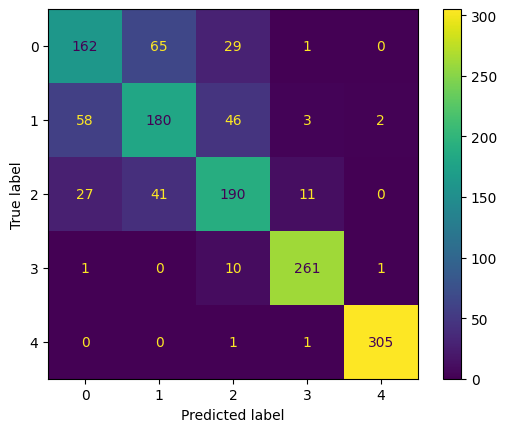

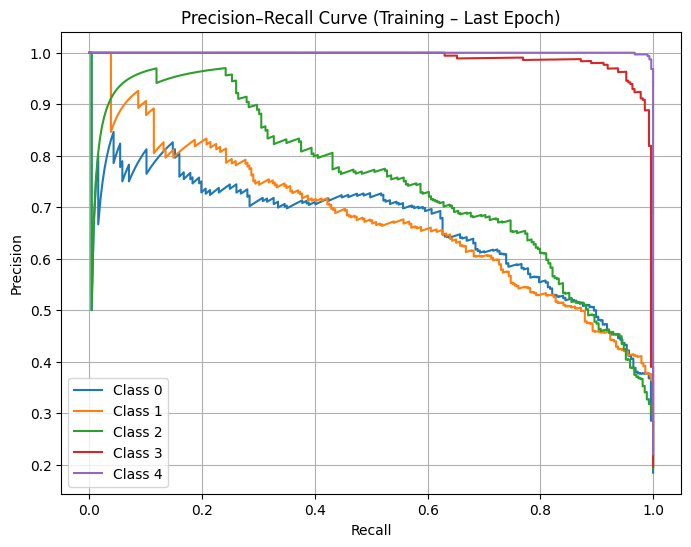

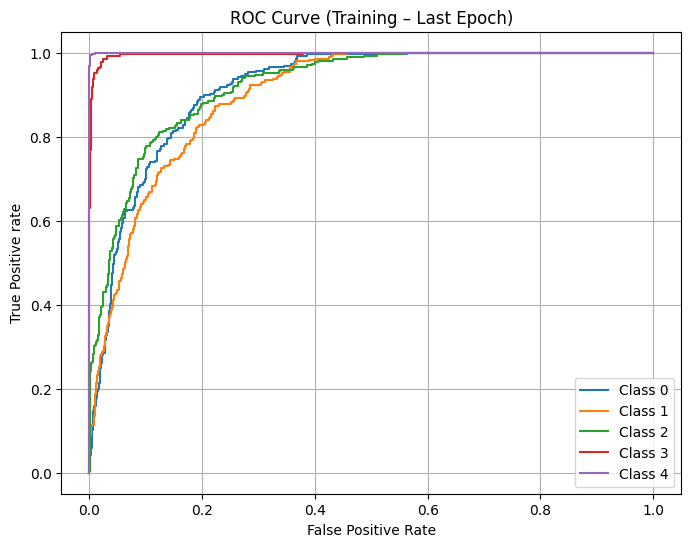

Test Accuracy: 60.74%, Recall: 0.45, Precision: 0.66, Specificity: 0.88, F1-Score: 0.48
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.77      0.77       204
           1       0.24      0.43      0.31        54
           2       0.58      0.32      0.41        69
           3       0.69      0.60      0.64        15
           4       1.00      0.14      0.25         7

    accuracy                           0.61       349
   macro avg       0.66      0.45      0.48       349
weighted avg       0.66      0.61      0.61       349



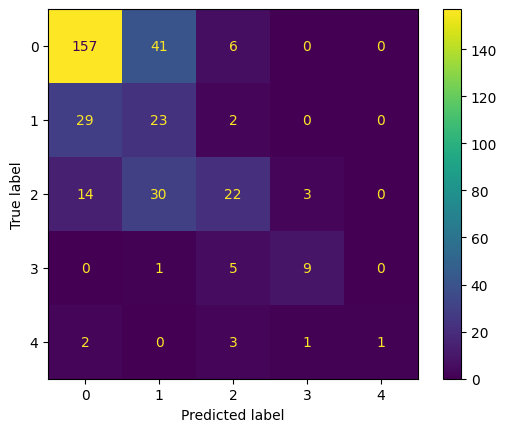

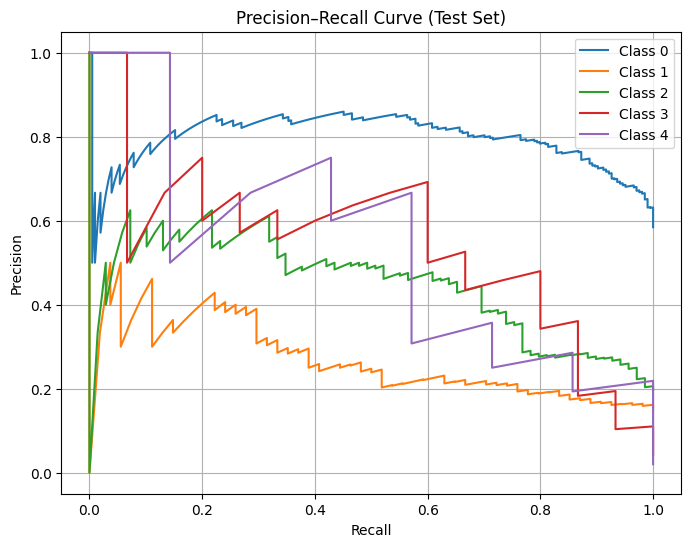

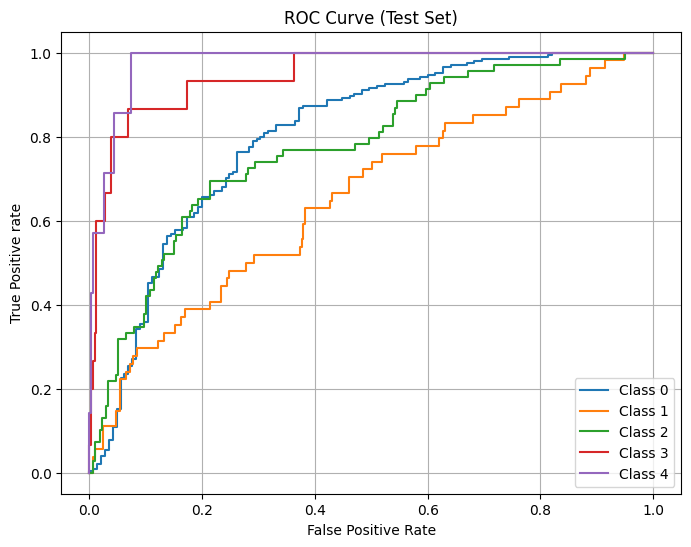

In [5]:
#With sampling

import torch
from torch import nn
import torchvision.transforms as transforms
from torchvision.transforms import v2
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision, MulticlassSpecificity, MulticlassF1Score
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
from collections import Counter

# Image transformer

train_transform = v2.Compose([
    v2.Resize(256),
    v2.RandomResizedCrop(
        size=224,
        scale=(0.8, 1.0),
        ratio=(0.9, 1.1)
    ),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(15),
    v2.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.2,
        hue=0.02
    ),
    v2.GaussianBlur(
        kernel_size=3,
        sigma=(0.1, 2.0)
    ),
    v2.ToImage(),
    v2.ToDtype(
        torch.float32,
        scale=True
    ),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
    v2.RandomErasing(
        p=0.25,
        scale=(0.02, 0.1),
        ratio=(0.3, 3.3),
        value='random'
    )
])

test_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Creates a custom dataset. Initialised with the csv file, image file and transformeded.

class messidorDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = Image.open(img_path).convert("RGB")
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

# Get the images and csv data file

annotations_file = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor_data.csv"
img_dir = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor-2/preprocess"
af = pd.read_csv(annotations_file)
num_imgs = len(af)
label = af.iloc[:, 1].values
indices = np.arange(len(af))

# Splits the dataset into training and testing sets in 80:20 ratio respectively

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(sss.split(indices, label))

training_dataset = messidorDataset(annotations_file, img_dir, train_transform)
testing_dataset = messidorDataset(annotations_file, img_dir, test_transform)

train_dataset = Subset(training_dataset, train_index)
test_dataset = Subset(testing_dataset, test_index)

targets = training_dataset.img_labels.iloc[train_dataset.indices, 1].values
num_samples = len(targets)
class_counts = torch.bincount(torch.tensor(targets))
sample_weights = torch.tensor([1.0 / class_counts[t] for t in targets])
train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

labels = testing_dataset.img_labels.iloc[test_dataset.indices, 1].values
unique, counts = np.unique(labels, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Class {u}: {c}")

# Loads the dataset, batchsize and shuffles the dataset

train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_counter = Counter()

for inputs, labels in train_loader:
    class_counter.update(labels.tolist())

print("Sampled class counts in one epoch:")
for cls in sorted(class_counter.keys()):
    print(f"Class {cls}: {class_counter[cls]}")

# Load ResNet18

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# This replaces the final layer of the model to output 5 classes instead of 1000

model.fc = nn.Sequential(
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 5)
)

# Freeze all layers except the last two layers.

for param in model.parameters():
    param.requires_grad = False
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Uses cuda if available or it uses cpu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss function and optimizer

criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam([
    {"params": model.layer3.parameters(), "lr": 1e-4},
    {"params": model.layer4.parameters(), "lr": 1e-4},
    {"params": model.fc.parameters(), "lr": 1e-4},
])

# Model training

total_epoch = 10
recall_macro = MulticlassRecall(num_classes=5, average="macro").to(device)
precision_macro = MulticlassPrecision(num_classes=5, average="macro").to(device)
specificity_macro = MulticlassSpecificity(num_classes=5, average="macro").to(device)
f1score_macro = MulticlassF1Score(num_classes=5, average="macro").to(device)
train_probs = []
pred_val = []
all_labels = []
for epoch in range(total_epoch):
    model.train()
    recall_macro.reset()
    precision_macro.reset()
    specificity_macro.reset()
    f1score_macro.reset()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        if epoch == total_epoch-1:
            probs = torch.softmax(outputs, dim=1)
            train_probs.append(probs.detach().numpy())
            pred_val.append(predicted.detach().numpy())
            all_labels.append(labels.detach().numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)

    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
    print(f'Epoch [{epoch+1}/{total_epoch}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
train_probs = np.concatenate(train_probs, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
recall_macro.reset()
precision_macro.reset()
specificity_macro.reset()
f1score_macro.reset()
correct = 0
total = 0
test_probs = []
pred_val = []
all_labels = []

# Model testing

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        probs = torch.softmax(outputs, dim=1)
        test_probs.append(probs.numpy())
        pred_val.append(predicted.numpy())
        all_labels.append(labels.numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)
    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
test_probs = np.concatenate(test_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))

for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()



Class 0: 204
Class 1: 54
Class 2: 69
Class 3: 15
Class 4: 7
Sampled class counts in one epoch:
Class 0: 319
Class 1: 274
Class 2: 239
Class 3: 281
Class 4: 282
Epoch [1/10], Loss: 1.3974, Accuracy: 40.65%, Recall: 0.41, Precision: 0.40, Specificity: 0.85, F1-Score: 0.40
Epoch [2/10], Loss: 1.1210, Accuracy: 57.20%, Recall: 0.57, Precision: 0.57, Specificity: 0.89, F1-Score: 0.56
Epoch [3/10], Loss: 1.0281, Accuracy: 60.86%, Recall: 0.60, Precision: 0.60, Specificity: 0.90, F1-Score: 0.60
Epoch [4/10], Loss: 0.9551, Accuracy: 65.66%, Recall: 0.65, Precision: 0.64, Specificity: 0.91, F1-Score: 0.64
Epoch [5/10], Loss: 0.8845, Accuracy: 72.62%, Recall: 0.73, Precision: 0.73, Specificity: 0.93, F1-Score: 0.72
Epoch [6/10], Loss: 0.8640, Accuracy: 73.48%, Recall: 0.73, Precision: 0.73, Specificity: 0.93, F1-Score: 0.73
Epoch [7/10], Loss: 0.8094, Accuracy: 77.28%, Recall: 0.76, Precision: 0.76, Specificity: 0.94, F1-Score: 0.76
Epoch [8/10], Loss: 0.7945, Accuracy: 78.14%, Recall: 0.78, Pre

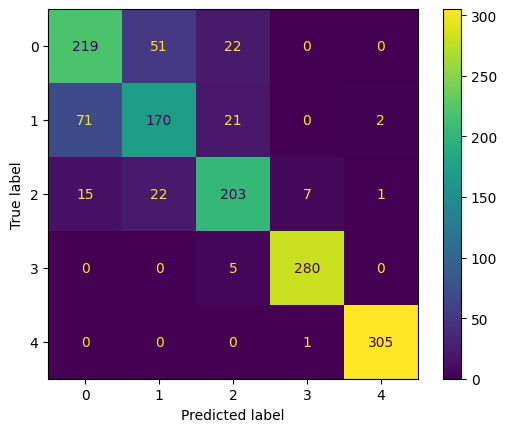

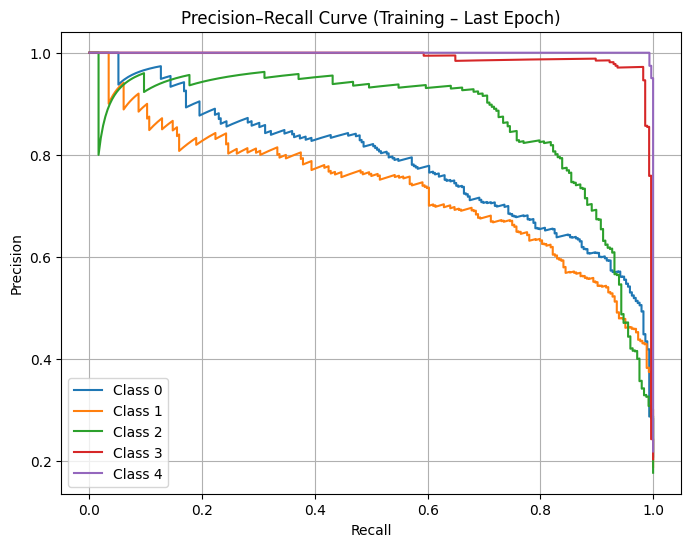

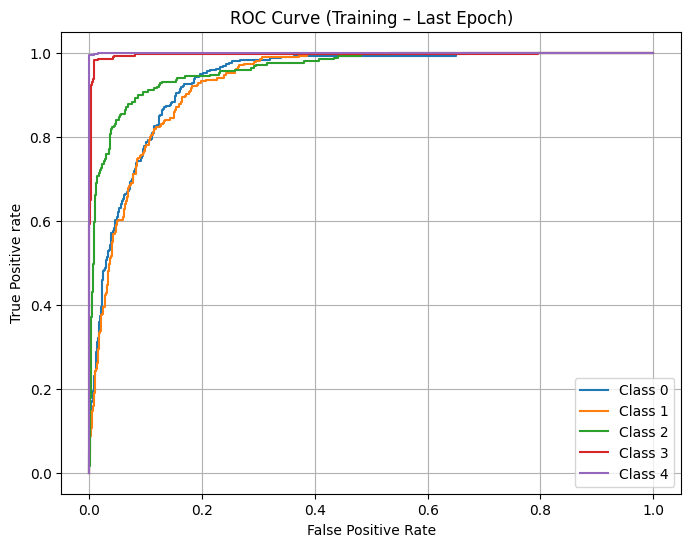

Test Accuracy: 64.47%, Recall: 0.59, Precision: 0.68, Specificity: 0.90, F1-Score: 0.58
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.70      0.76       204
           1       0.26      0.43      0.32        54
           2       0.67      0.62      0.65        69
           3       0.61      0.93      0.74        15
           4       1.00      0.29      0.44         7

    accuracy                           0.64       349
   macro avg       0.68      0.59      0.58       349
weighted avg       0.71      0.64      0.66       349



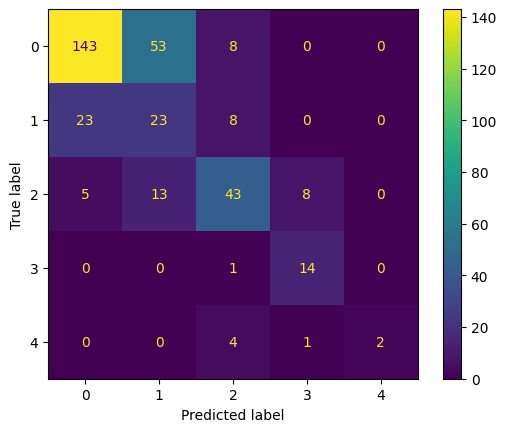

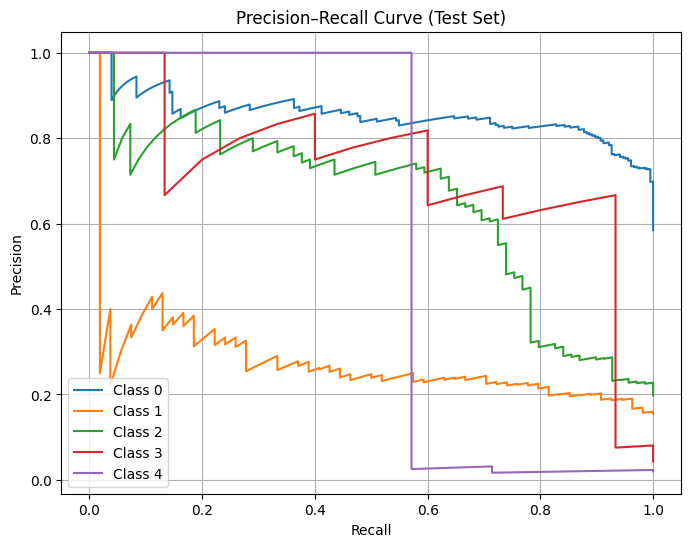

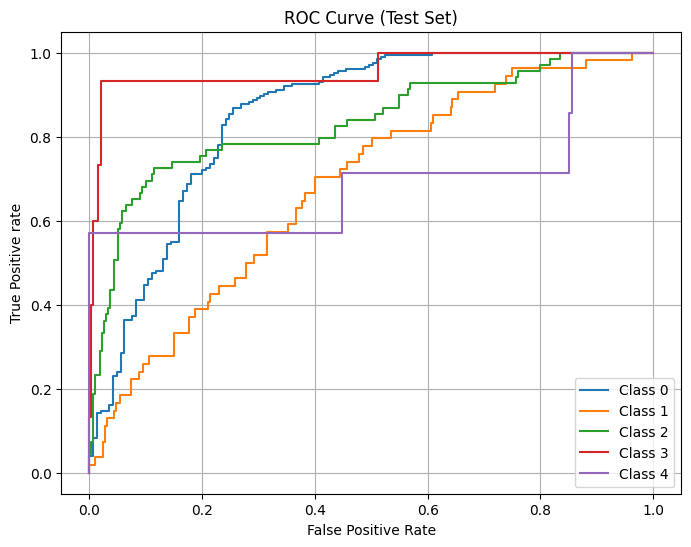

In [4]:
#Improved data augmentation, Label smoothing, dropout and feature reduction
#Only fine-tuning last layer and claassifier

import torch
from torch import nn
import torchvision.transforms as transforms
from torchvision.transforms import v2
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision, MulticlassSpecificity, MulticlassF1Score
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
from collections import Counter

# Image transformer

train_transform = v2.Compose([
    v2.Resize(256),
    v2.RandomResizedCrop(
        size=224,
        scale=(0.8, 1.0),
        ratio=(0.9, 1.1)
    ),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(15),
    v2.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.2,
        hue=0.02
    ),
    v2.GaussianBlur(
        kernel_size=3,
        sigma=(0.1, 2.0)
    ),
    v2.ToImage(),
    v2.ToDtype(
        torch.float32,
        scale=True
    ),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
    v2.RandomErasing(
        p=0.25,
        scale=(0.02, 0.1),
        ratio=(0.3, 3.3),
        value='random'
    )
])

test_transform = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

# Creates a custom dataset. Initialised with the csv file, image file and transformeded.

class messidorDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = Image.open(img_path).convert("RGB")
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

# Get the images and csv data file

annotations_file = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor_data.csv"
img_dir = "/mnt/c/Users/matth/CS408/MESSIDOR-2_from_kaggle/messidor-2/preprocess"
af = pd.read_csv(annotations_file)
num_imgs = len(af)
label = af.iloc[:, 1].values
indices = np.arange(len(af))

# Splits the dataset into training and testing sets in 80:20 ratio respectively

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(sss.split(indices, label))

training_dataset = messidorDataset(annotations_file, img_dir, train_transform)
testing_dataset = messidorDataset(annotations_file, img_dir, test_transform)

train_dataset = Subset(training_dataset, train_index)
test_dataset = Subset(testing_dataset, test_index)

targets = training_dataset.img_labels.iloc[train_dataset.indices, 1].values
num_samples = len(targets)
class_counts = torch.bincount(torch.tensor(targets))
sample_weights = torch.tensor([1.0 / class_counts[t] for t in targets])
train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

labels = testing_dataset.img_labels.iloc[test_dataset.indices, 1].values
unique, counts = np.unique(labels, return_counts=True)

for u, c in zip(unique, counts):
    print(f"Class {u}: {c}")

# Loads the dataset, batchsize and shuffles the dataset

train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_counter = Counter()

for inputs, labels in train_loader:
    class_counter.update(labels.tolist())

print("Sampled class counts in one epoch:")
for cls in sorted(class_counter.keys()):
    print(f"Class {cls}: {class_counter[cls]}")

# Load ResNet18

model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

# This replaces the final layer of the model to output 5 classes instead of 1000

model.classifier[-1] = nn.Sequential(
    nn.Linear(768, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 5)
)

# Freeze all layers except the last two layers.

for param in model.parameters():
    param.requires_grad = False
for param in model.features[-3].parameters():
    param.requires_grad = True
for param in model.features[-2].parameters():
    param.requires_grad = True
for param in model.features[-1].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True

# Uses cuda if available or it uses cpu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss function and optimizer

criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam([
    {"params": model.features[-3].parameters(), "lr": 1e-4},
    {"params": model.features[-2].parameters(), "lr": 1e-4},
    {"params": model.features[-1].parameters(), "lr": 1e-4},
    {"params": model.classifier[-1].parameters(), "lr": 1e-3},
])

# Model training

total_epoch = 10
recall_macro = MulticlassRecall(num_classes=5, average="macro").to(device)
precision_macro = MulticlassPrecision(num_classes=5, average="macro").to(device)
specificity_macro = MulticlassSpecificity(num_classes=5, average="macro").to(device)
f1score_macro = MulticlassF1Score(num_classes=5, average="macro").to(device)
train_probs = []
pred_val = []
all_labels = []
for epoch in range(total_epoch):
    model.train()
    recall_macro.reset()
    precision_macro.reset()
    specificity_macro.reset()
    f1score_macro.reset()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        if epoch == total_epoch-1:
            probs = torch.softmax(outputs, dim=1)
            train_probs.append(probs.detach().numpy())
            pred_val.append(predicted.detach().numpy())
            all_labels.append(labels.detach().numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)

    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
    print(f'Epoch [{epoch+1}/{total_epoch}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
train_probs = np.concatenate(train_probs, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        train_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Training – Last Epoch)")
plt.legend()
plt.grid(True)
plt.show()

model.eval()
recall_macro.reset()
precision_macro.reset()
specificity_macro.reset()
f1score_macro.reset()
correct = 0
total = 0
test_probs = []
pred_val = []
all_labels = []

# Model testing

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        probs = torch.softmax(outputs, dim=1)
        test_probs.append(probs.numpy())
        pred_val.append(predicted.numpy())
        all_labels.append(labels.numpy())
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        recall_macro.update(predicted, labels)
        precision_macro.update(predicted, labels)
        specificity_macro.update(predicted, labels)
        f1score_macro.update(predicted, labels)
    recall = recall_macro.compute().item()
    precision = precision_macro.compute().item()
    specificity = specificity_macro.compute().item()
    f1score = f1score_macro.compute().item()
print(f'Test Accuracy: {100 * correct / total:.2f}%, Recall: {recall:.2f}, Precision: {precision:.2f}, Specificity: {specificity:.2f}, F1-Score: {f1score:.2f}')
test_probs = np.concatenate(test_probs, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
pred_val = np.concatenate(pred_val, axis=0)
print("Classification Report:\n", classification_report(all_labels, pred_val, labels=[0,1,2,3,4]))
cm = confusion_matrix(all_labels, pred_val, labels=[0,1,2,3,4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

plt.figure(figsize=(8,6))

for c in range(5):
    precision, recall, _ = precision_recall_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(recall, precision, label=f"Class {c}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for c in range(5):
    false_pos, true_pos, _ = roc_curve(
        (all_labels == c).astype(int),
        test_probs[:, c]
    )
    plt.plot(false_pos, true_pos, label=f"Class {c}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive rate")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.show()

